# P2

## Get the data:

In [56]:
library(quantmod)

# seed
set.seed(53600945)

# generate 100 random integers from the range 1 to 377
random_indices <- sample(1:377, 100, replace = FALSE)

# read tickers
symbols_df <- read.csv("symbols2.csv", sep = ",", header = TRUE)

#print(symbols_df)

#print(random_indices)


# select tickers based on the generated random numbers
selected_tickers <- symbols_df$Symbol[random_indices]


print(selected_tickers)

# start and end dates for the data download
start_date <- as.Date("2020-01-01")
end_date <- as.Date("2022-10-31")

# list to store the stock data
stock_data_list <- list()

# loop through the selected tickers and download the stock price data
for(ticker in selected_tickers) {
  # tryCatch fction is used to ignore errors (if the stock is not available or so)
  stock_data <- tryCatch({
    getSymbols(ticker, src = 'yahoo', from = start_date, to = end_date, auto.assign = FALSE)
  }, error = function(e) NULL)
  
  # if stock data was downloaded, add it to the list
  if (!is.null(stock_data)) {
    stock_data_list[[ticker]] <- stock_data
  }
}

#print(head(stock_data_list))

  [1] GILD KSS  ABC  BA   AEE  TRV  PCG  AN   BMC  RL   CL   AZO  TXN  MSFT HES 
 [16] NRG  CAH  IP   ETR  FITB HAS  IRM  TEL  PDCO SCHW CVS  IFF  COF  SE   IR  
 [31] FE   JPM  PNC  NFLX XRX  WMB  CVX  FTI  FISV V    NEE  PHM  NOV  KO   PBCT
 [46] MO   GCI  LRCX BSX  PG   MMM  RSG  HSY  EFX  ROST EXPD PLD  FDX  HOG  BBBY
 [61] DRI  HST  INTU AEP  GIS  BK   ADBE TAP  MNST BIIB PGR  PSA  IGT  CHRW ICE 
 [76] VZ   MAS  HAL  DVN  PKI  BAC  VRSN BAX  EBAY SLM  PSX  PXD  CMI  A    CMS 
 [91] YUM  WEC  LLL  T    AXP  MDT  MCK  EA   WDC  PRU 
377 Levels: A AA AAPL ABC ABT ACE ACN ADBE ADI ADM ADP ADSK AEE AEP AES ... ZION


Warning message:
"BMC contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."

## Compute the log returns:

In [57]:
# fction to compute logarithmic returns
compute_log_returns <- function(stock_prices) {
  
  log_returns <- diff(log(Cl(stock_prices)))
  return(log_returns)
}

# a list to store the logarithmic returns for each stock
log_returns_list <- list()

# loop through each of the stock's data in 'stock_data_list' to compute the logarithmic returns
for(ticker in names(stock_data_list)) {
  stock_prices <- stock_data_list[[ticker]]
  log_returns <- compute_log_returns(stock_prices)
  log_returns_list[[ticker]] <- log_returns
}

#print(log_returns_list)


## Compute mean log returns:

In [58]:

# combine all the logarithmic returns into one dataframe
# each column represents a stock, and each row represents a date
combined_log_returns <- do.call(merge, c(log_returns_list, all = TRUE))

# mean logarithmic return for each date
mean_log_returns <- rowMeans(combined_log_returns, na.rm = TRUE)

# convert the mean logarithmic returns to a dataframe 
mean_log_returns_df <- data.frame(Date = index(combined_log_returns), MeanLogReturn = mean_log_returns)

head(mean_log_returns_df)


Date,MeanLogReturn
2020-01-02,NaN
2020-01-03,-0.0044412149
2020-01-06,0.0009751704
2020-01-07,-0.0020736697
2020-01-08,0.0021340068
2020-01-09,0.0025843238


# ARMA identification and estimation:

In [59]:
# clean the data from missing observations
clean_data <- na.omit(mean_log_returns_df)


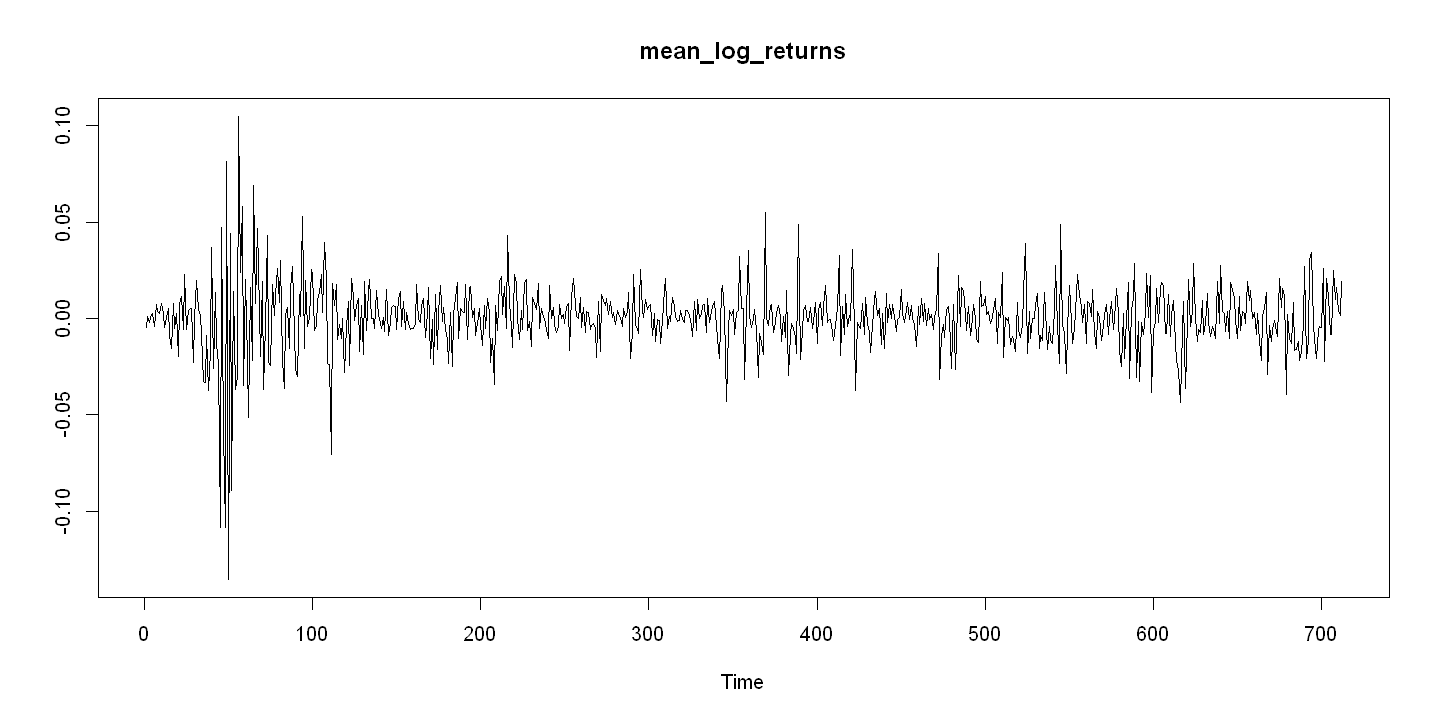

In [62]:
options(repr.plot.width = 12, repr.plot.height = 6)

plot.ts(clean_data$MeanLogReturn, ylab = NA, main = 'mean_log_returns')

 We can see a pattern typical for financial returns data, that are very likely mean stationary. There seem to be clusters of higher volatility, with the most significant one at the beginning of our data, which covers mainly the year 2020. We might argue that this was due to the onset of COVID-19 and related economic uncertainty. The mean stationarity of the series is further tested using ADF and KPSS tests below.

In [63]:
#install.packages('tseries')

rets = clean_data$MeanLogReturn

In [64]:
library(tseries)


Box.test(rets, type = 'Ljung-Box')

adf.test(rets, k = 1)

kpss.test(rets, null = 'Level')
kpss.test(rets, null = 'Trend')


	Box-Ljung test

data:  rets
X-squared = 16.618, df = 1, p-value = 4.572e-05


Warning message in adf.test(rets, k = 1):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  rets
Dickey-Fuller = -17.867, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(rets, null = "Level"):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  rets
KPSS Level = 0.085825, Truncation lag parameter = 6, p-value = 0.1


Warning message in kpss.test(rets, null = "Trend"):
"p-value greater than printed p-value"


	KPSS Test for Trend Stationarity

data:  rets
KPSS Trend = 0.088488, Truncation lag parameter = 6, p-value = 0.1


The Ljung-Box Q test rejects the null hypothesis of no autocorrelation. This suggests that past values might have a predictive power on future values in our series.

Based on the ADF test, we reject the null hypothesis of unit root; suggesting mean stationarity. Since ADF test tests just for a specific form of non-stationarity (unit root) we conduct a KPSS test. 

Based on the KPSS test, we do not reject the null hypothesis of neither level (around a mean) or trend (around a trend of the series) stationarity. All on the 5% sign. level.

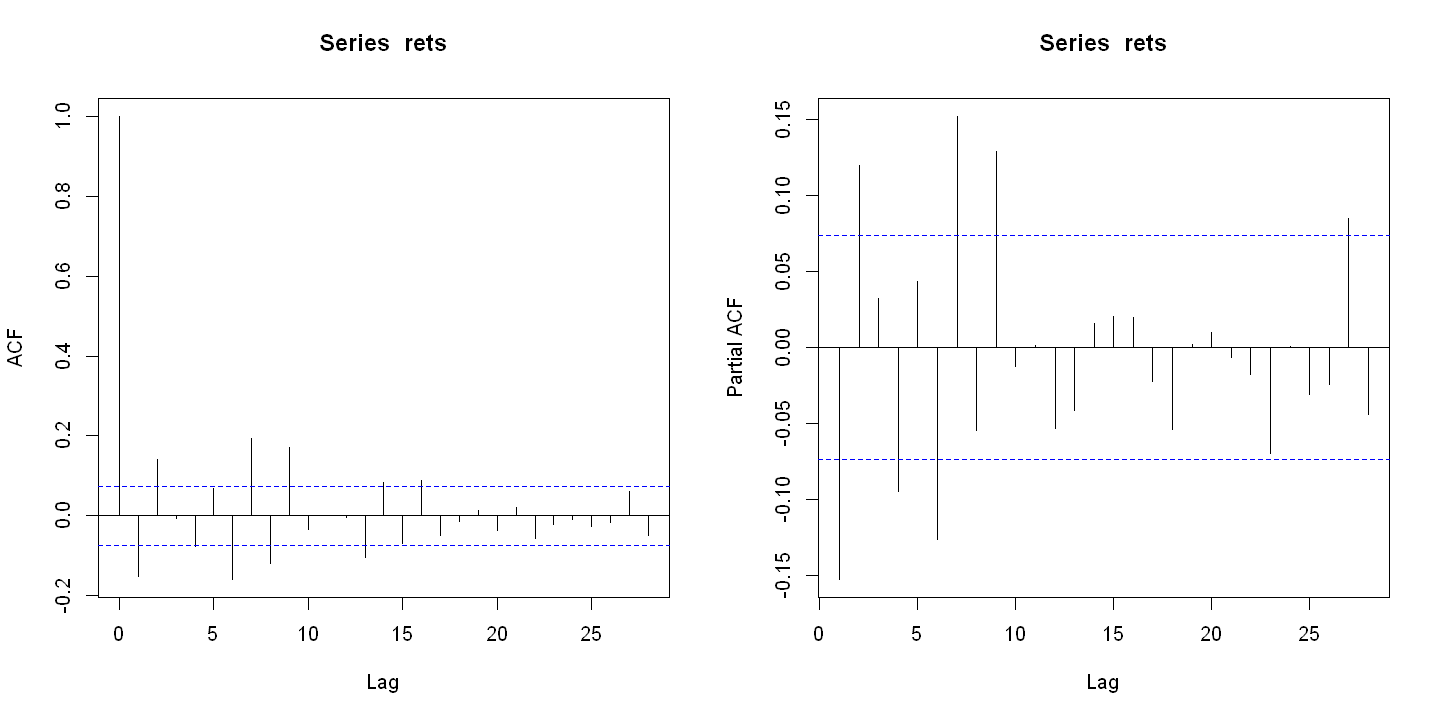

In [65]:

options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))


# autocorrelation and partial autocorrelation fctions
acf(rets)
pacf(rets)

#print(clean_data)

Based on the plotted PACF we estimate AR(2), AR(4), and AR(7). We chose those based on the displayed significant lags. 

We suspect that AR(9) might work the best, however it is also a model of a probably too high order, possibly leading to overfitting our data.

Since it is not clear from the plots whether to use AR or MA model, we later estimate MA models and the combination of both model types as well. For now we focus on the AR models only.

Series: rets 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
          ar1     ar2   mean
      -0.1342  0.1195  1e-04
s.e.   0.0372  0.0372  7e-04

sigma^2 estimated as 0.0003178:  log likelihood=1858.47
AIC=-3708.93   AICc=-3708.88   BIC=-3690.66

Training set error measures:
                        ME      RMSE       MAE     MPE     MAPE      MASE
Training set -2.070596e-06 0.0177889 0.0118035 111.181 152.3466 0.6677799
                    ACF1
Training set -0.00410459


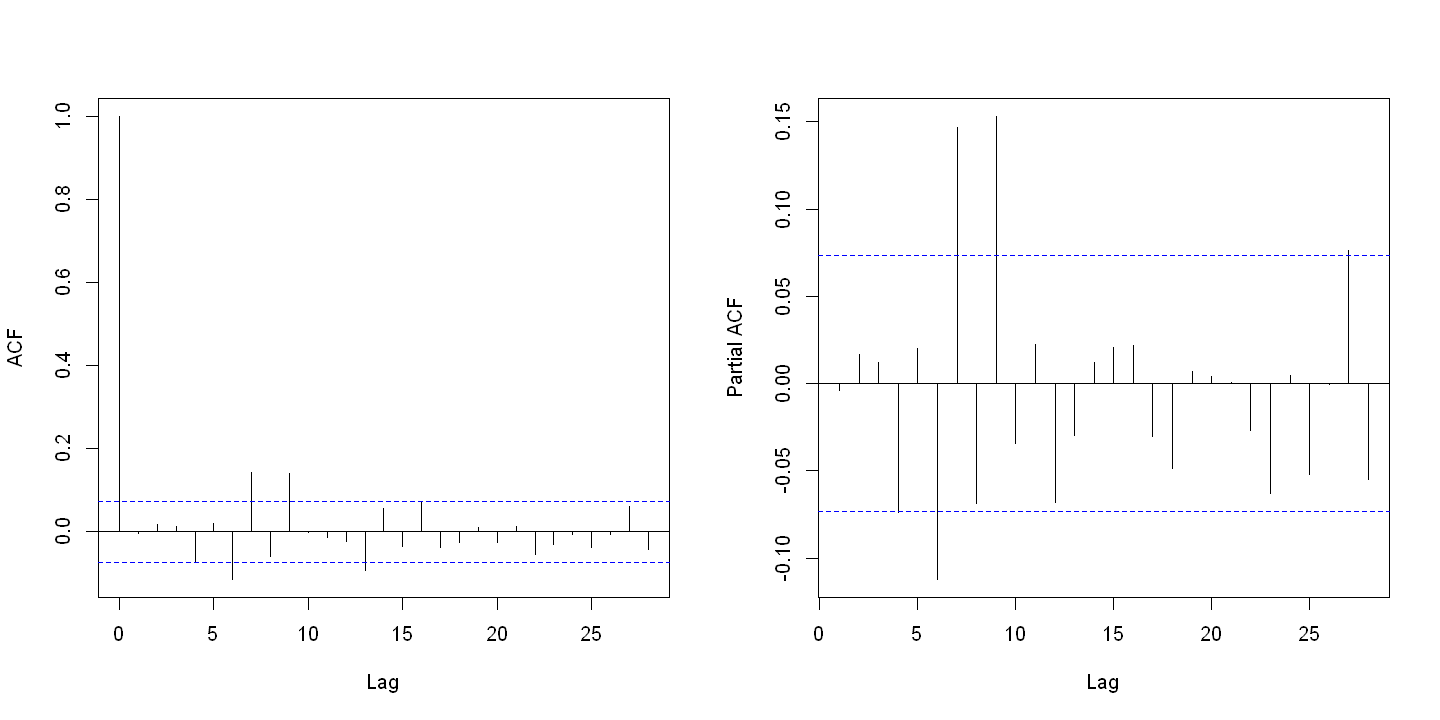

In [66]:
library(forecast)
rets_ar2 <- Arima(rets, order = c(2, 0, 0))
summary (rets_ar2)

par(mfrow = c(1, 2))
acf(rets_ar2$residuals, main = NA)
pacf(rets_ar2$residuals, main = NA)

In [67]:
Box.test(rets_ar2$residuals, type = "Ljung-Box", lag = 1)

Box.test(rets_ar2$residuals, type = "Ljung-Box", lag = 4)

Box.test(rets_ar2$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_ar2$residuals, type = "Ljung-Box", lag = 12)


	Box-Ljung test

data:  rets_ar2$residuals
X-squared = 0.012046, df = 1, p-value = 0.9126



	Box-Ljung test

data:  rets_ar2$residuals
X-squared = 4.1934, df = 4, p-value = 0.3805



	Box-Ljung test

data:  rets_ar2$residuals
X-squared = 31.275, df = 8, p-value = 0.0001255



	Box-Ljung test

data:  rets_ar2$residuals
X-squared = 45.93, df = 12, p-value = 7.134e-06


From the PACF of the estimated AR(2) model we can see that it does not 'smoothen' the autocorellation well. This can be seen also on the low p-values of the Box-Ljung tests at the higher lags. Hence, there is still a room for a better model.

Series: rets 
ARIMA(4,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4   mean
      -0.1351  0.1357  0.0193  -0.0946  1e-04
s.e.   0.0373  0.0376  0.0376   0.0373  6e-04

sigma^2 estimated as 0.0003155:  log likelihood=1862.05
AIC=-3712.1   AICc=-3711.98   BIC=-3684.69

Training set error measures:
                        ME       RMSE        MAE     MPE     MAPE      MASE
Training set -3.227799e-06 0.01769911 0.01189232 110.001 155.8783 0.6728052
                    ACF1
Training set 0.003912051



	Box-Ljung test

data:  rets_ar4$residuals
X-squared = 0.010943, df = 1, p-value = 0.9167



	Box-Ljung test

data:  rets_ar4$residuals
X-squared = 0.35275, df = 4, p-value = 0.9862



	Box-Ljung test

data:  rets_ar4$residuals
X-squared = 25.212, df = 8, p-value = 0.001431



	Box-Ljung test

data:  rets_ar4$residuals
X-squared = 38.983, df = 12, p-value = 0.0001059


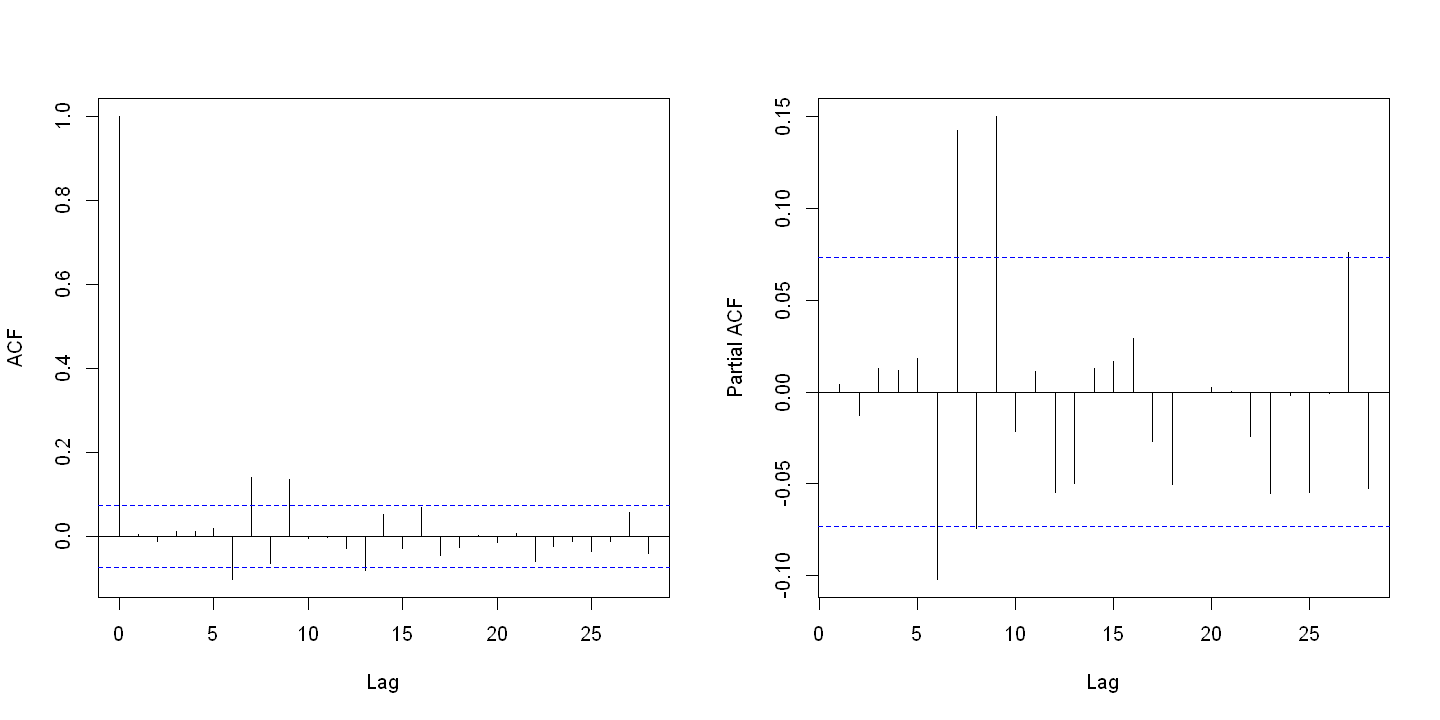

In [68]:
library(forecast)
rets_ar4 <- Arima(rets, order = c(4, 0, 0))
summary (rets_ar4)

par(mfrow = c(1, 2))
acf(rets_ar4$residuals, main = NA)
pacf(rets_ar4$residuals, main = NA)

Box.test(rets_ar4$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets_ar4$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_ar4$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_ar4$residuals, type = "Ljung-Box", lag = 12)

Similarly as for the AR(2) model, the AR(4) does not have a very good fit based on both PACF and the B-L tests.

Series: rets 
ARIMA(7,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ar5     ar6     ar7   mean
      -0.1064  0.1196  0.0260  -0.0739  0.0081  -0.107  0.1513  1e-04
s.e.   0.0370  0.0370  0.0373   0.0371  0.0372   0.037  0.0370  7e-04

sigma^2 estimated as 0.0003039:  log likelihood=1876.75
AIC=-3735.49   AICc=-3735.24   BIC=-3694.38

Training set error measures:
                        ME       RMSE       MAE      MPE     MAPE      MASE
Training set -5.369222e-07 0.01733427 0.0118586 90.33673 182.6282 0.6708971
                    ACF1
Training set 0.008128606



	Box-Ljung test

data:  rets_ar7$residuals
X-squared = 0.047243, df = 1, p-value = 0.8279



	Box-Ljung test

data:  rets_ar7$residuals
X-squared = 0.87643, df = 4, p-value = 0.9279



	Box-Ljung test

data:  rets_ar7$residuals
X-squared = 2.6374, df = 8, p-value = 0.955



	Box-Ljung test

data:  rets_ar7$residuals
X-squared = 14.857, df = 12, p-value = 0.2493


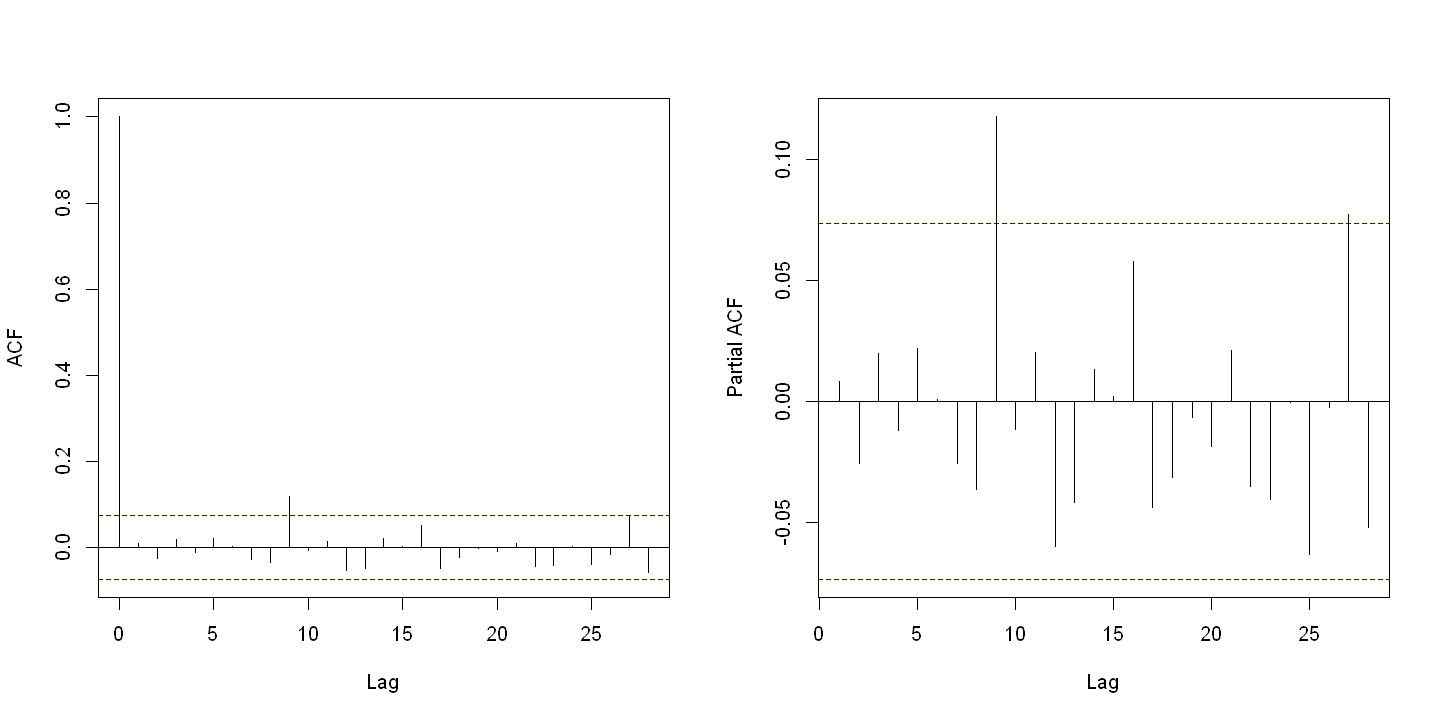

In [69]:
library(forecast)
rets_ar7 <- Arima(rets, order = c(7, 0, 0))
summary (rets_ar7)

par(mfrow = c(1, 2))
acf(rets_ar7$residuals, main = NA)
pacf(rets_ar7$residuals, main = NA)

Box.test(rets_ar7$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets_ar7$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_ar7$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_ar7$residuals, type = "Ljung-Box", lag = 12)

The AR(7) model seems to have much better fit based on all the p-values above the 5% sign. threshold of the B-L tests for various lags. However if one looks at the PACF there are still two significant lags.

Series: rets 
ARIMA(9,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ar5      ar6     ar7      ar8
      -0.0909  0.0948  0.0394  -0.0790  0.0196  -0.1037  0.1309  -0.0414
s.e.   0.0372  0.0373  0.0371   0.0369  0.0370   0.0369  0.0371   0.0372
         ar9   mean
      0.1280  2e-04
s.e.  0.0371  7e-04

sigma^2 estimated as 0.0002988:  log likelihood=1883.7
AIC=-3745.39   AICc=-3745.01   BIC=-3695.14

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 3.266408e-06 0.01716385 0.01176954 88.66789 190.9659 0.6658586
                    ACF1
Training set 0.001528027



	Box-Ljung test

data:  rets_ar9$residuals
X-squared = 0.0016694, df = 1, p-value = 0.9674



	Box-Ljung test

data:  rets_ar9$residuals
X-squared = 0.058962, df = 4, p-value = 0.9996



	Box-Ljung test

data:  rets_ar9$residuals
X-squared = 0.10545, df = 8, p-value = 1



	Box-Ljung test

data:  rets_ar9$residuals
X-squared = 2.7896, df = 12, p-value = 0.9969


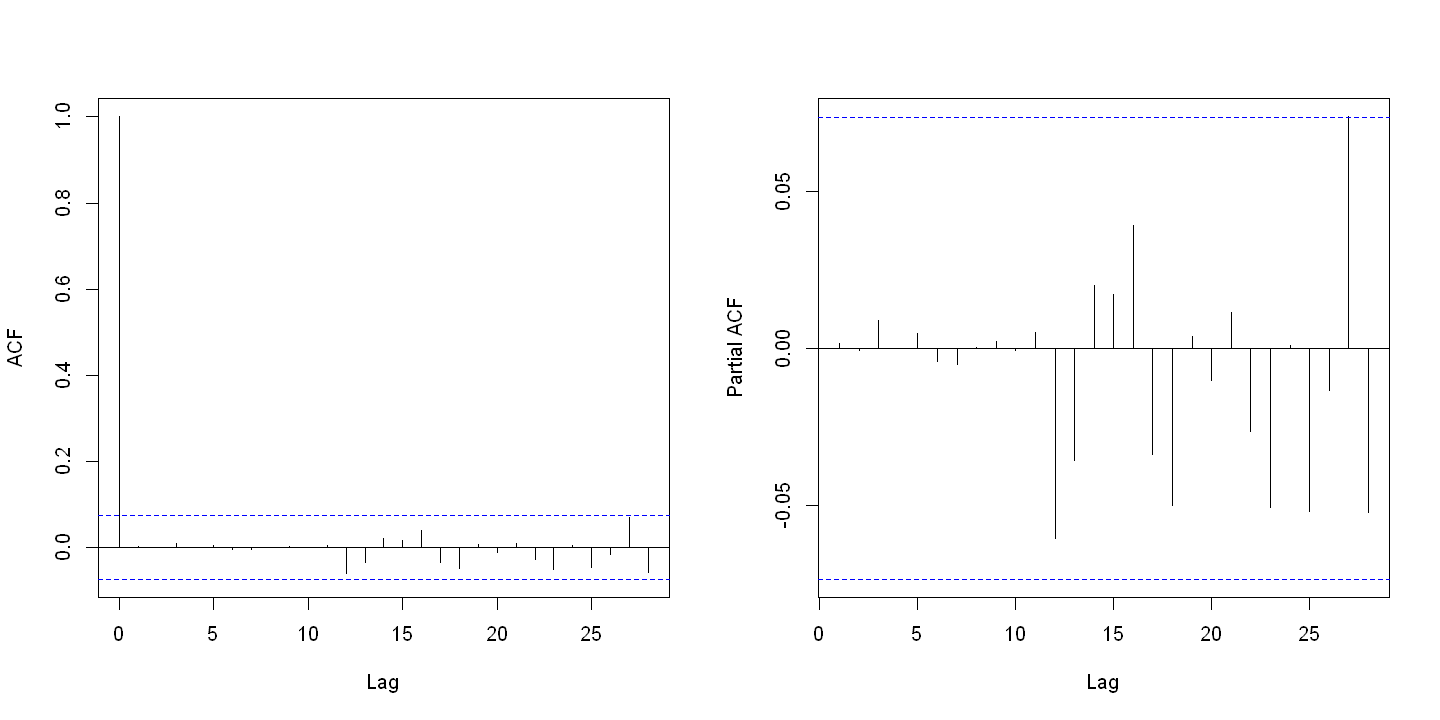

In [70]:
library(forecast)
rets_ar9 <- Arima(rets, order = c(9, 0, 0))
summary (rets_ar9)

par(mfrow = c(1, 2))
acf(rets_ar9$residuals, main = NA)
pacf(rets_ar9$residuals, main = NA)

Box.test(rets_ar9$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets_ar9$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_ar9$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_ar9$residuals, type = "Ljung-Box", lag = 12)

As expected the AR(9) works quite well with all the B-L tests p-values almost 1 and one barely significant lag on the PACF. However we continue with model identification since we want as parsimonious model as possible.

Based on the ACF of our returns data plotted earlier we suspect an MA(1) process:

Series: rets 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
          ma1   mean
      -0.1214  1e-04
s.e.   0.0330  6e-04

sigma^2 estimated as 0.0003235:  log likelihood=1851.6
AIC=-3697.2   AICc=-3697.17   BIC=-3683.5

Training set error measures:
                        ME       RMSE        MAE    MPE     MAPE      MASE
Training set -1.739631e-06 0.01796173 0.01181228 113.86 128.9496 0.6682766
                    ACF1
Training set -0.01699059



	Box-Ljung test

data:  rets_ma1$residuals
X-squared = 0.20641, df = 1, p-value = 0.6496



	Box-Ljung test

data:  rets_ma1$residuals
X-squared = 17.842, df = 4, p-value = 0.001325



	Box-Ljung test

data:  rets_ma1$residuals
X-squared = 57.382, df = 8, p-value = 1.517e-09



	Box-Ljung test

data:  rets_ma1$residuals
X-squared = 76.176, df = 12, p-value = 2.201e-11


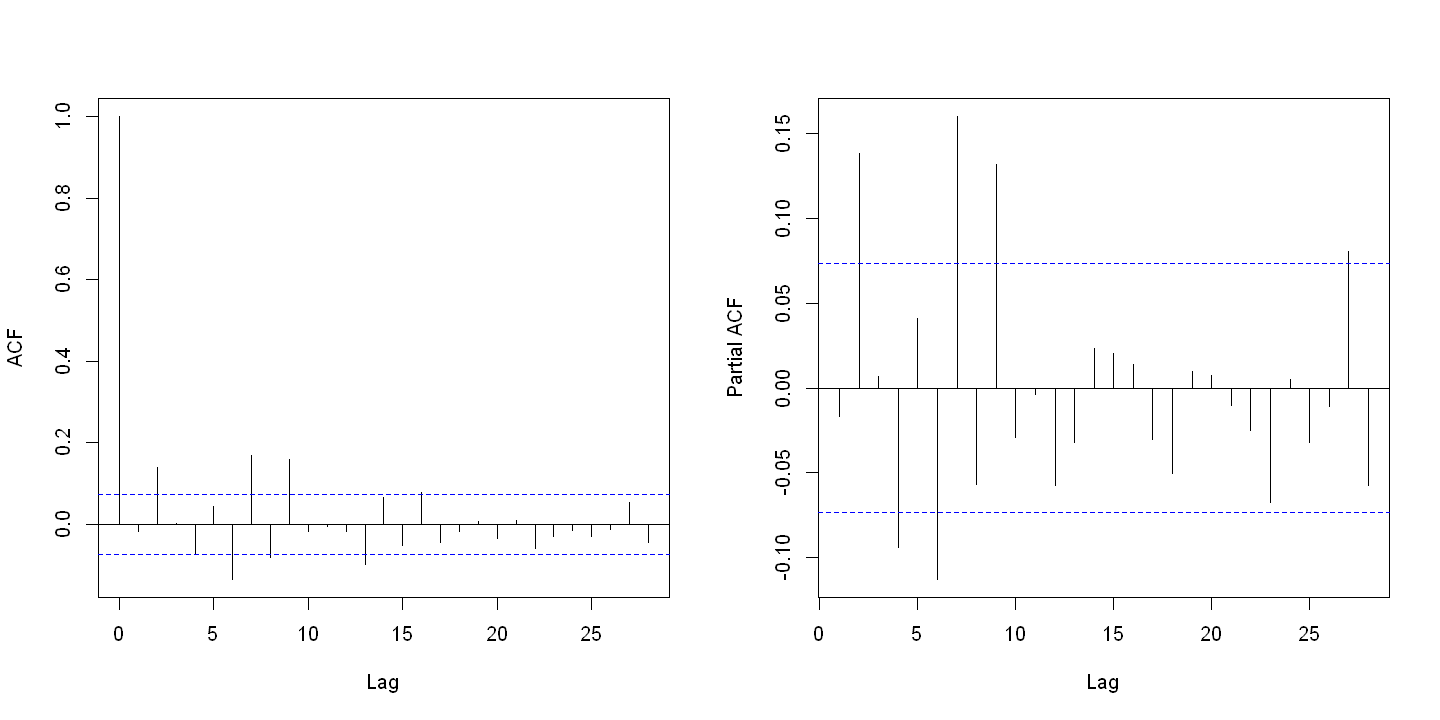

In [71]:
library(forecast)
rets_ma1 <- Arima(rets, order = c(0, 0, 1))
summary (rets_ma1)

par(mfrow = c(1, 2))
acf(rets_ma1$residuals, main = NA)
pacf(rets_ma1$residuals, main = NA)

Box.test(rets_ma1$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets_ma1$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_ma1$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_ma1$residuals, type = "Ljung-Box", lag = 12)

This model does not look very well based on both the B-L tests for higher lags as well as the plot. 

We try the auto-arima fction:

In [72]:
auto.arima(rets)

Series: rets 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.1317  0.1559
s.e.   0.0368  0.0382

sigma^2 estimated as 0.0003165:  log likelihood=1859.42
AIC=-3712.85   AICc=-3712.81   BIC=-3699.14

Thus we try the suggested MA(2) model:

Series: rets 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.1317  0.1559
s.e.   0.0368  0.0382

sigma^2 estimated as 0.0003165:  log likelihood=1859.42
AIC=-3712.85   AICc=-3712.81   BIC=-3699.14

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0001424417 0.01776486 0.01185128 108.5303 159.3976 0.6704833
                     ACF1
Training set -0.003817845



	Box-Ljung test

data:  rets_ma2$residuals
X-squared = 0.010422, df = 1, p-value = 0.9187



	Box-Ljung test

data:  rets_ma2$residuals
X-squared = 2.7541, df = 4, p-value = 0.5998



	Box-Ljung test

data:  rets_ma2$residuals
X-squared = 30.312, df = 8, p-value = 0.0001861



	Box-Ljung test

data:  rets_ma2$residuals
X-squared = 45.48, df = 12, p-value = 8.526e-06


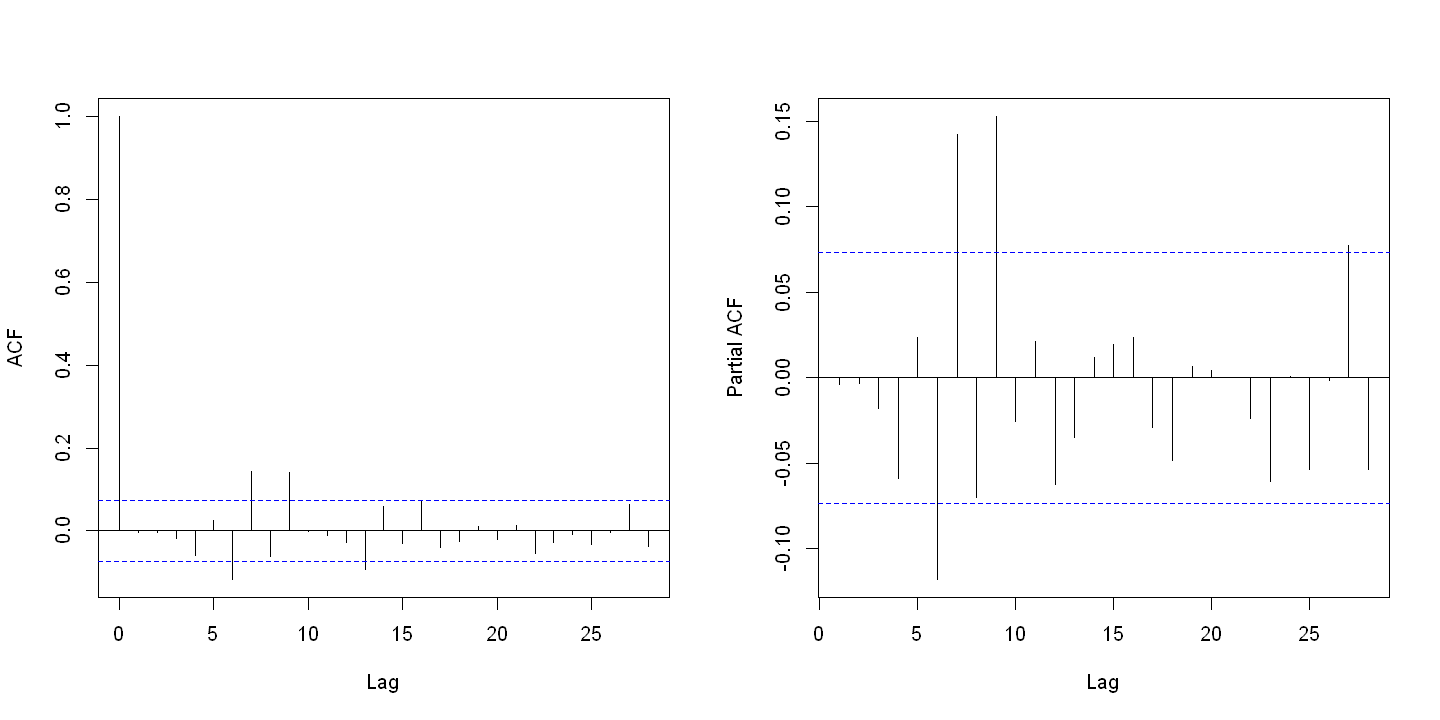

In [30]:
library(forecast)
rets_ma2 <- Arima(rets, order = c(0, 0, 2), include.mean = FALSE)
summary (rets_ma2)

par(mfrow = c(1, 2))
acf(rets_ma2$residuals, main = NA)
pacf(rets_ma2$residuals, main = NA)


Box.test(rets_ma2$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets_ma2$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_ma2$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_ma2$residuals, type = "Ljung-Box", lag = 12)

This model, however, behaves not very differently from the MA(2) model. It does not have much better fit.

Therefore we try a combination of the AR and MA models:

Series: rets 
ARIMA(4,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ar3     ar4     ma1     ma2   mean
      -1.6484  -0.7093  0.1152  0.0345  1.5657  0.6722  1e-04
s.e.   0.1307   0.1414  0.0759  0.0561  0.1245  0.1099  7e-04

sigma^2 estimated as 0.0003015:  log likelihood=1879.01
AIC=-3742.03   AICc=-3741.82   BIC=-3705.48

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 6.194407e-07 0.01727824 0.01177362 97.09086 187.8723 0.6660895
                      ACF1
Training set -0.0004020138



	Box-Ljung test

data:  rets_arma42$residuals
X-squared = 0.00011556, df = 1, p-value = 0.9914



	Box-Ljung test

data:  rets_arma42$residuals
X-squared = 0.46808, df = 4, p-value = 0.9765



	Box-Ljung test

data:  rets_arma42$residuals
X-squared = 5.2949, df = 8, p-value = 0.7256



	Box-Ljung test

data:  rets_arma42$residuals
X-squared = 11.872, df = 12, p-value = 0.456


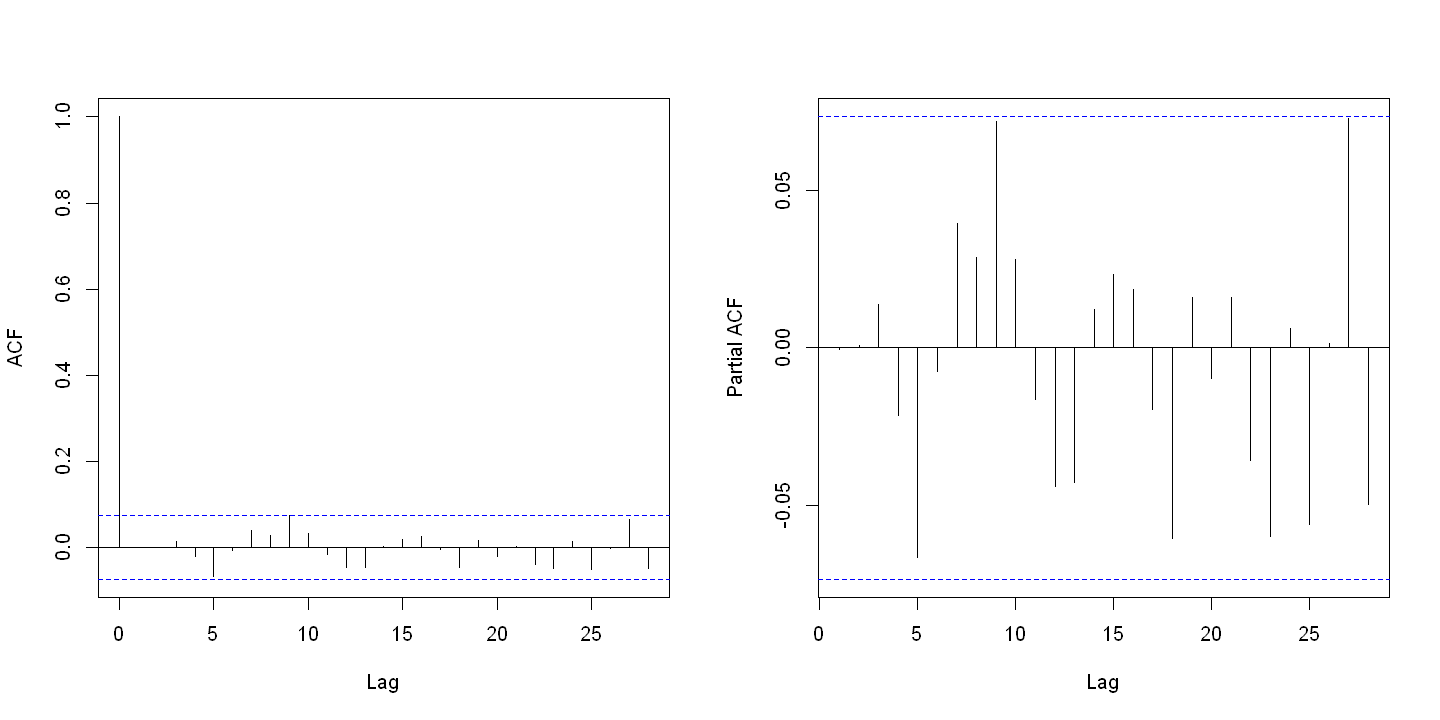

In [73]:
library(forecast)
rets_arma42 <- Arima(rets, order = c(4, 0, 2))
summary (rets_arma42)

par(mfrow = c(1, 2))
acf(rets_arma42$residuals, main = NA)
pacf(rets_arma42$residuals, main = NA)

Box.test(rets_arma42$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets_arma42$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_arma42$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_arma42$residuals, type = "Ljung-Box", lag = 12)

The ARMA(4,2) model seems to be the best model based on the acf, pacf, as well as the tests (all p-values much higher than 0.05). acf as well as pacf have no significant lags.

Next we compare the estimated models based on the AIC and BIC criteria:

In [74]:
models <- 7
criteria <- matrix(ncol = 2, nrow = models)
colnames(criteria) <- c('AIC', 'BIC')
rownames(criteria) <- c('AR(2)','AR(4)', 'AR(7)', 'AR(9)','ARMA(4,2)','MA(1)','MA(2)')

criteria[1, 1] <- rets_ar2$aic
criteria[1, 2] <- rets_ar2$bic
criteria[2, 1] <- rets_ar4$aic
criteria[2, 2] <- rets_ar4$bic
criteria[3, 1] <- rets_ar7$aic
criteria[3, 2] <- rets_ar7$bic

criteria[4, 1] <- rets_ar9$aic
criteria[4, 2] <- rets_ar9$bic
criteria[5, 1] <- rets_arma42$aic
criteria[5, 2] <- rets_arma42$bic
criteria[6, 1] <- rets_ma1$aic
criteria[6, 2] <- rets_ma1$bic
criteria[7, 1] <- rets_ma2$aic
criteria[7, 2] <- rets_ma2$bic

criteria

,AIC,BIC
AR(2),-3708.933,-3690.660
AR(4),-3712.099,-3684.691
AR(7),-3735.492,-3694.380
AR(9),-3745.391,-3695.142
"ARMA(4,2)",-3742.028,-3705.483
MA(1),-3697.202,-3683.497
MA(2),-3712.848,-3699.144


We would choose arma(4,2) due to the  lowest values apart from the AIC of the AR(9) model.

The final plot of fitted vs actual follows:

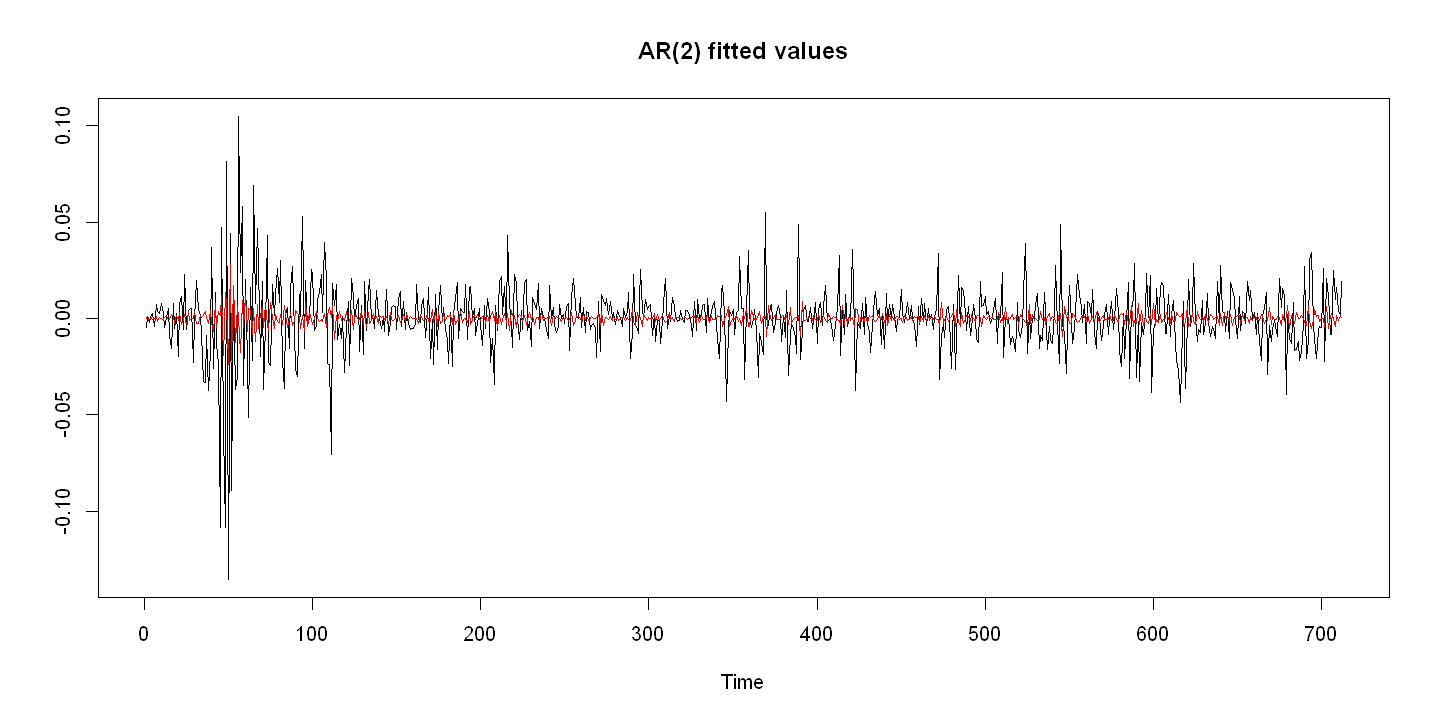

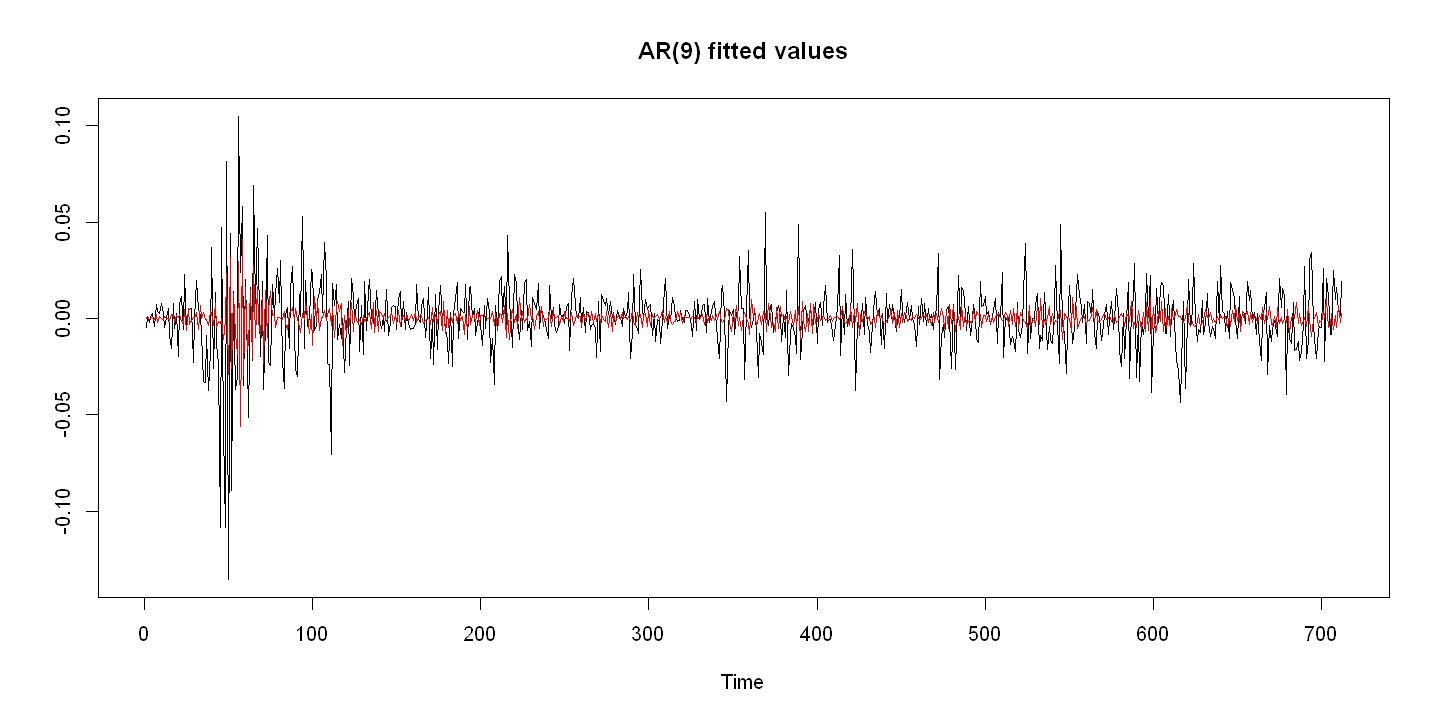

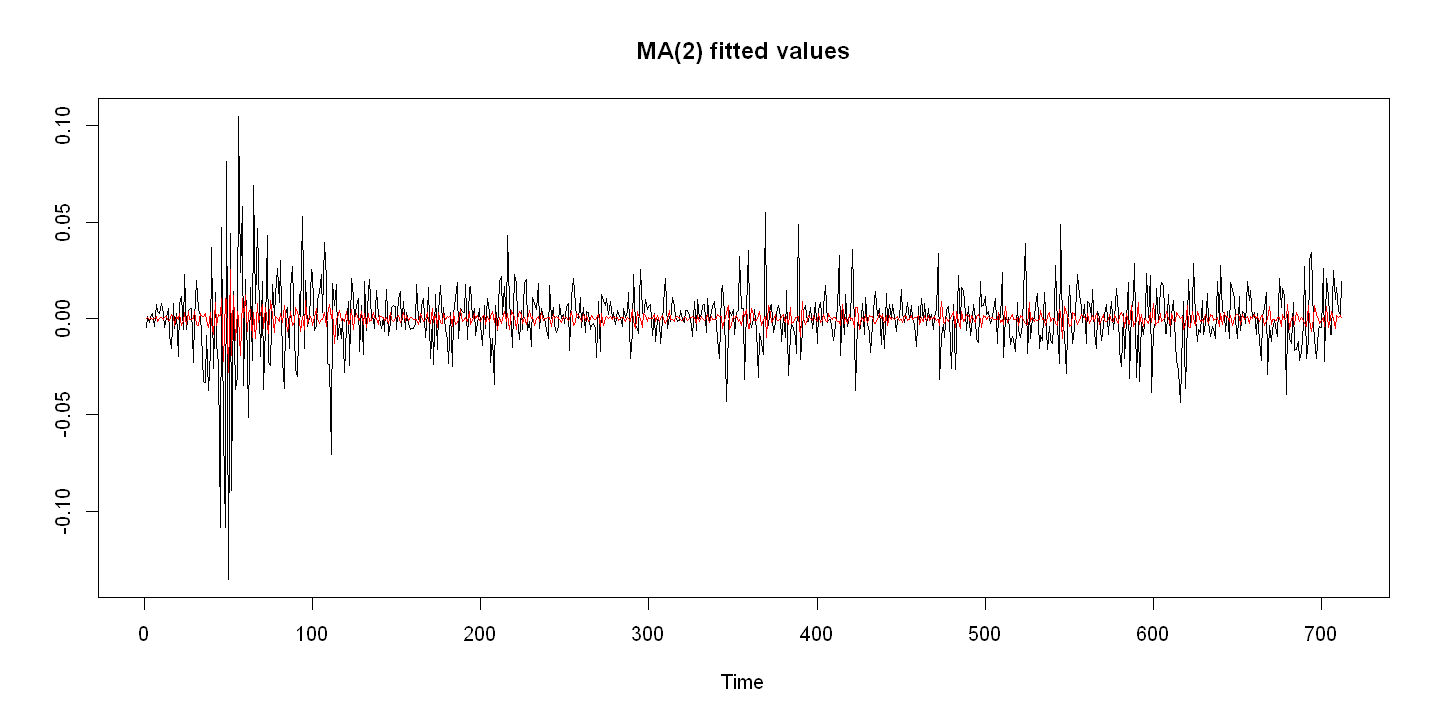

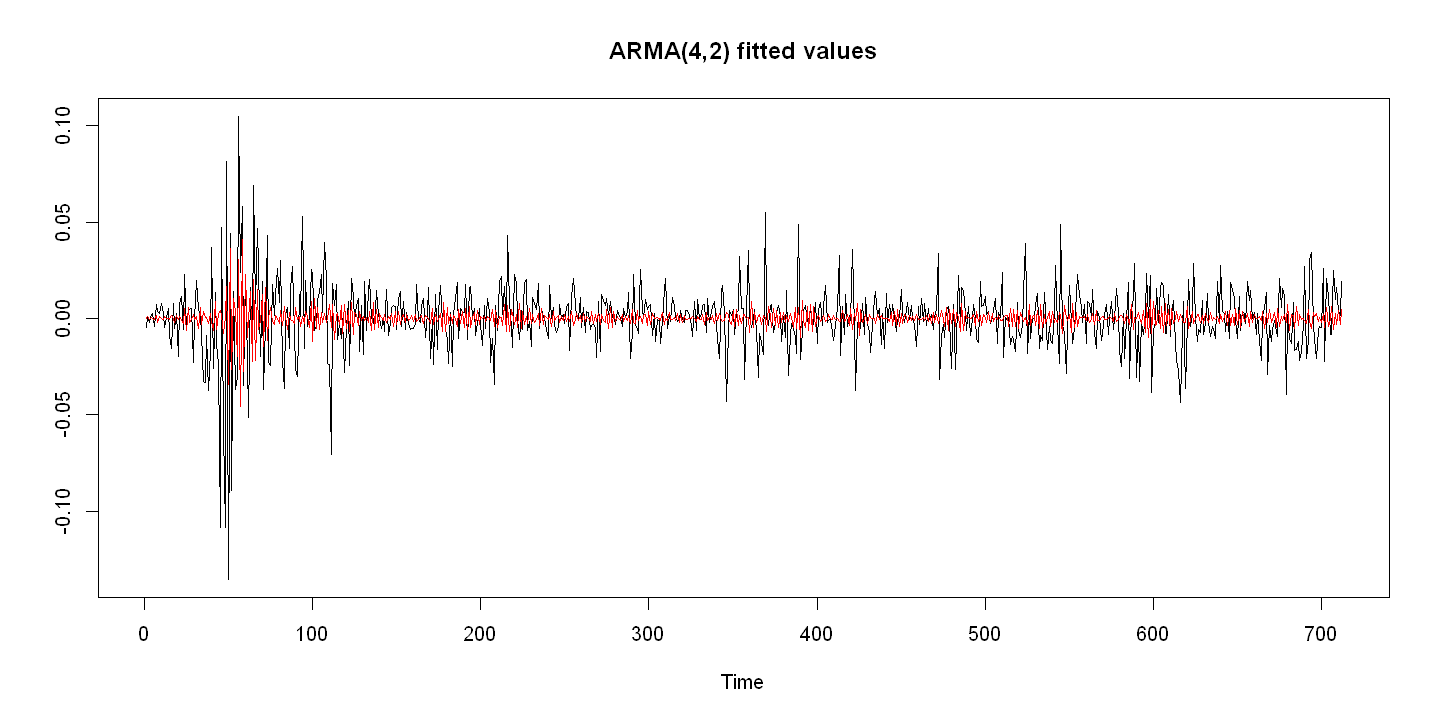

In [75]:
plot.ts(rets, ylab = NA, main = 'AR(2) fitted values')
lines(rets_ar2$fitted, col = 'red')

plot.ts(rets, ylab = NA, main = 'AR(9) fitted values')
lines(rets_ar9$fitted, col = 'red')

plot.ts(rets, ylab = NA, main = 'MA(2) fitted values')
lines(rets_ma2$fitted, col = 'red')

plot.ts(rets, ylab = NA, main = 'ARMA(4,2) fitted values')
lines(rets_arma42$fitted, col = 'red')

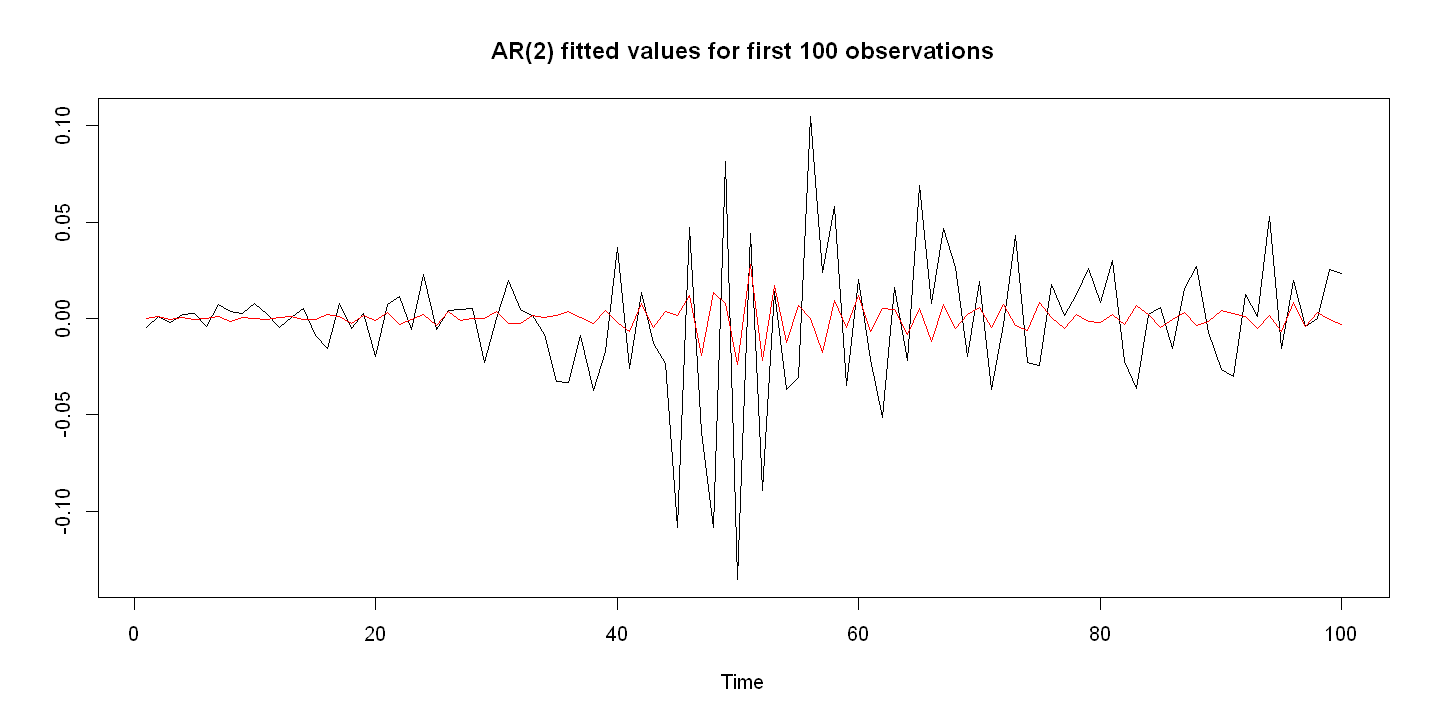

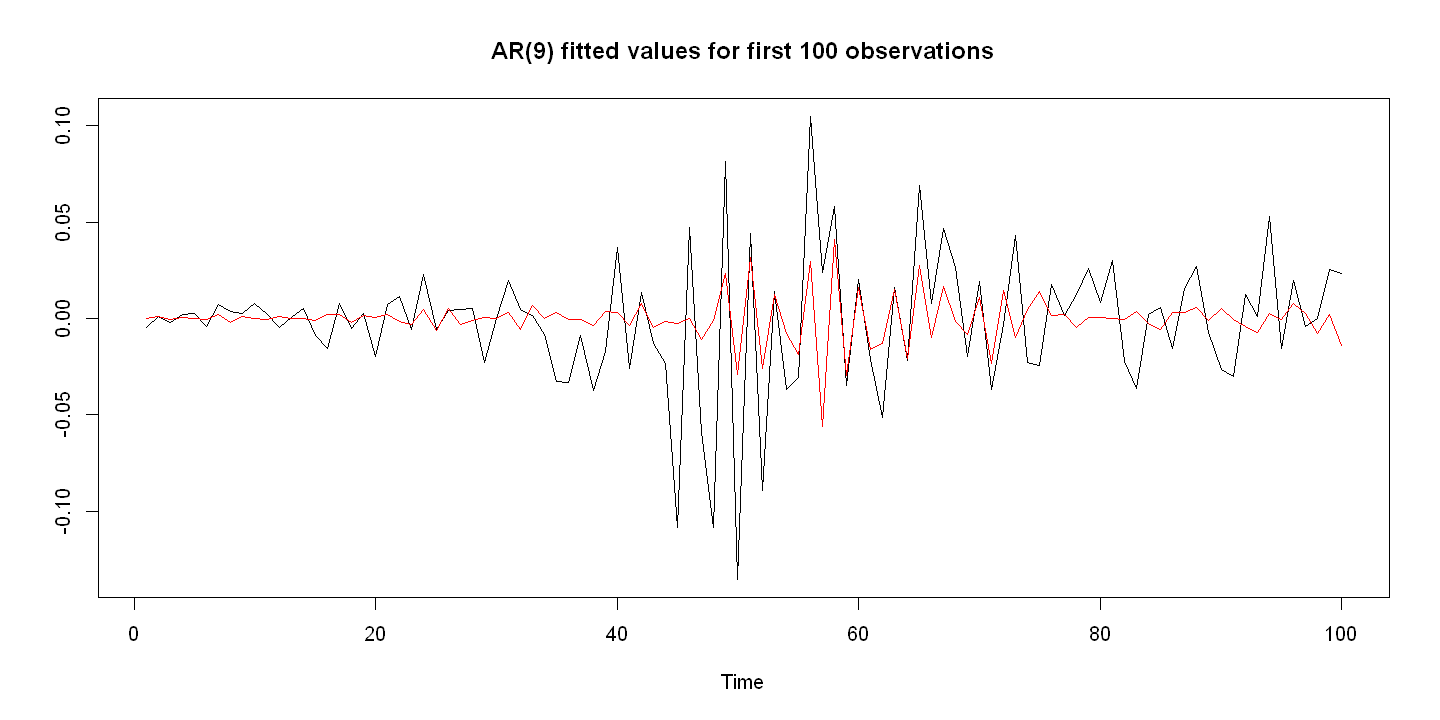

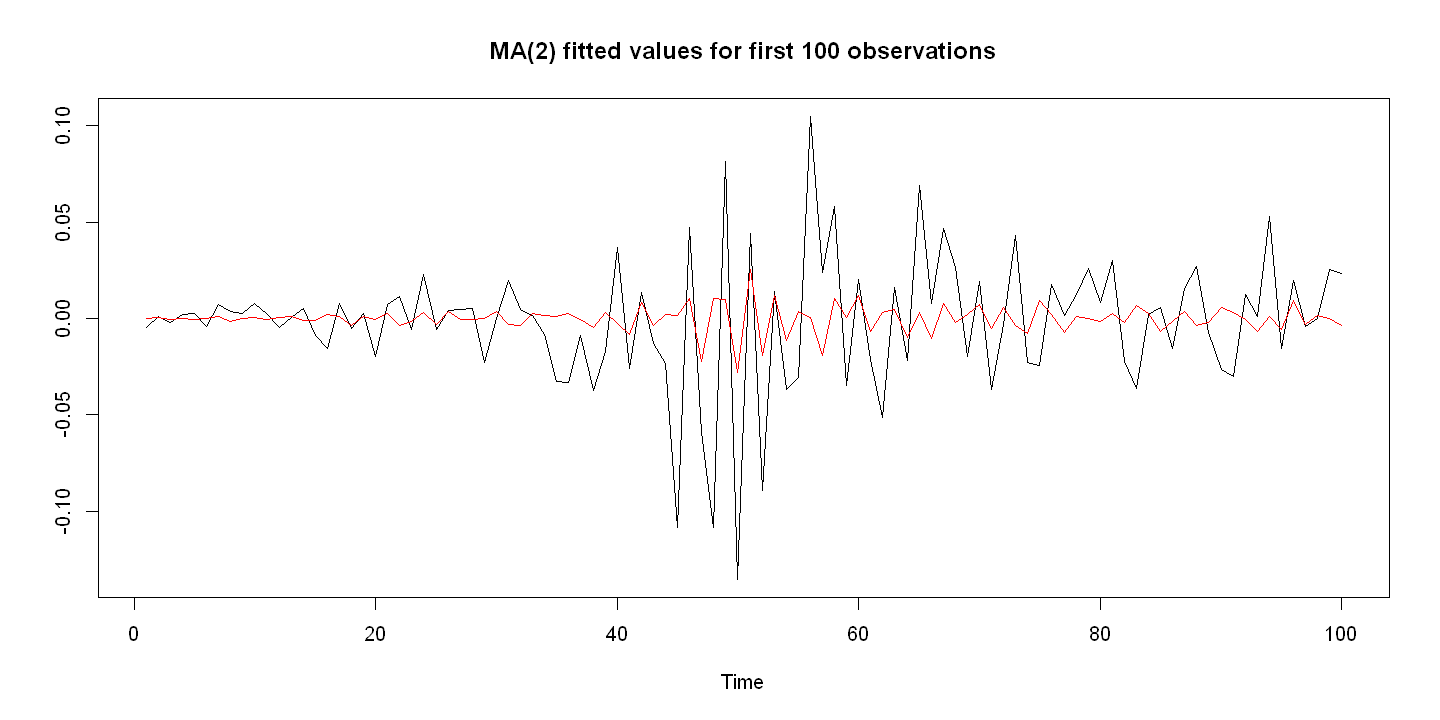

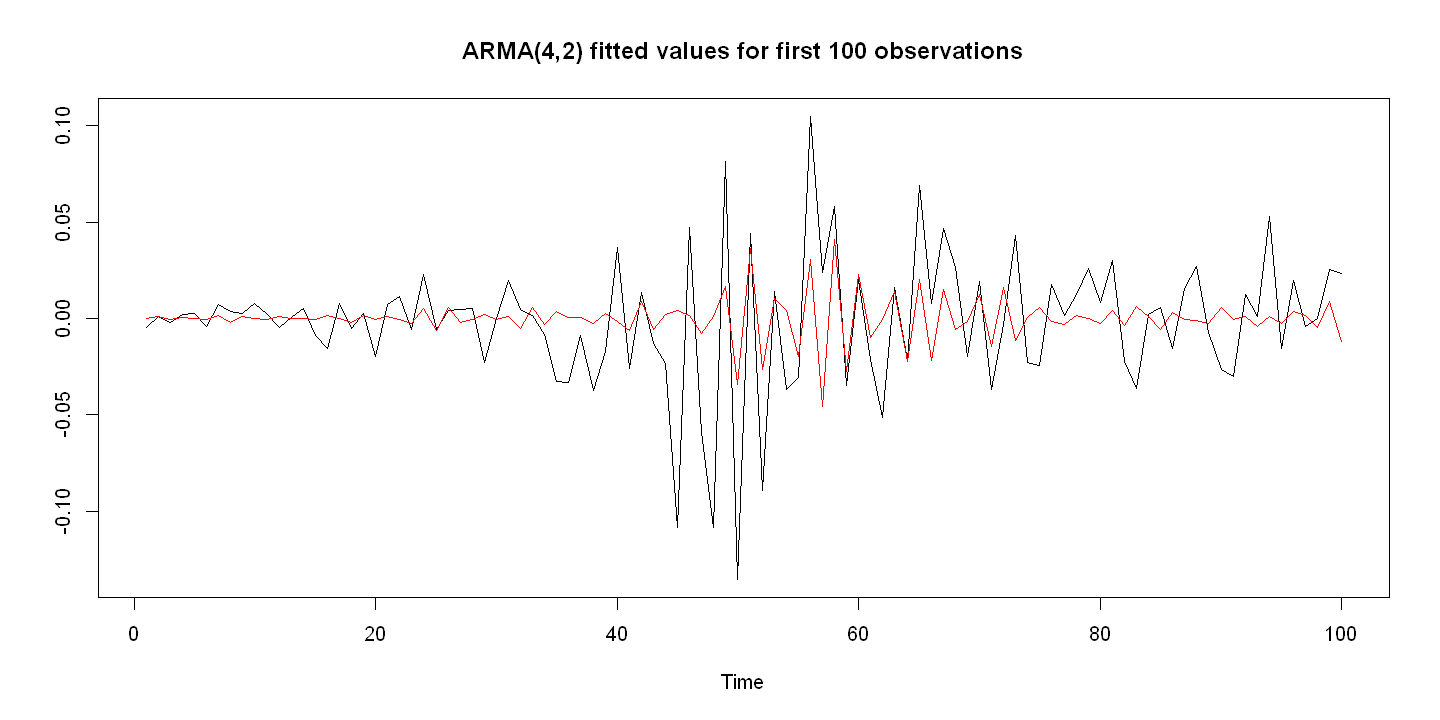

In [76]:
# AR(2) Model
plot.ts(rets[1:100], ylab = NA, main = 'AR(2) fitted values for first 100 observations')
lines(rets_ar2$fitted[1:100], col = 'red')

# AR(9) Model
plot.ts(rets[1:100], ylab = NA, main = 'AR(9) fitted values for first 100 observations')
lines(rets_ar9$fitted[1:100], col = 'red')

# MA(2) Model
plot.ts(rets[1:100], ylab = NA, main = 'MA(2) fitted values for first 100 observations')
lines(rets_ma2$fitted[1:100], col = 'red')

# ARMA(4,2) Model
plot.ts(rets[1:100], ylab = NA, main = 'ARMA(4,2) fitted values for first 100 observations')
lines(rets_arma42$fitted[1:100], col = 'red')

## Divide the data to two parts - since it is fitting differently for the higher volatility period than the rest:

Based on the actual vs fitted values graphs we can see that in the cluster of the high volatility, the models seem to fit the data well. However, in the rest, the fit seems to be worse. Therefore we would divide the data to two parts and identify the models for both parts again...

The analysis just of the first part of the divided dataset follows. Nevertheless, it is almost identical to the analysis of the whole dataset conducted above. Thus the following analyisis is just illustrative, without any comments.

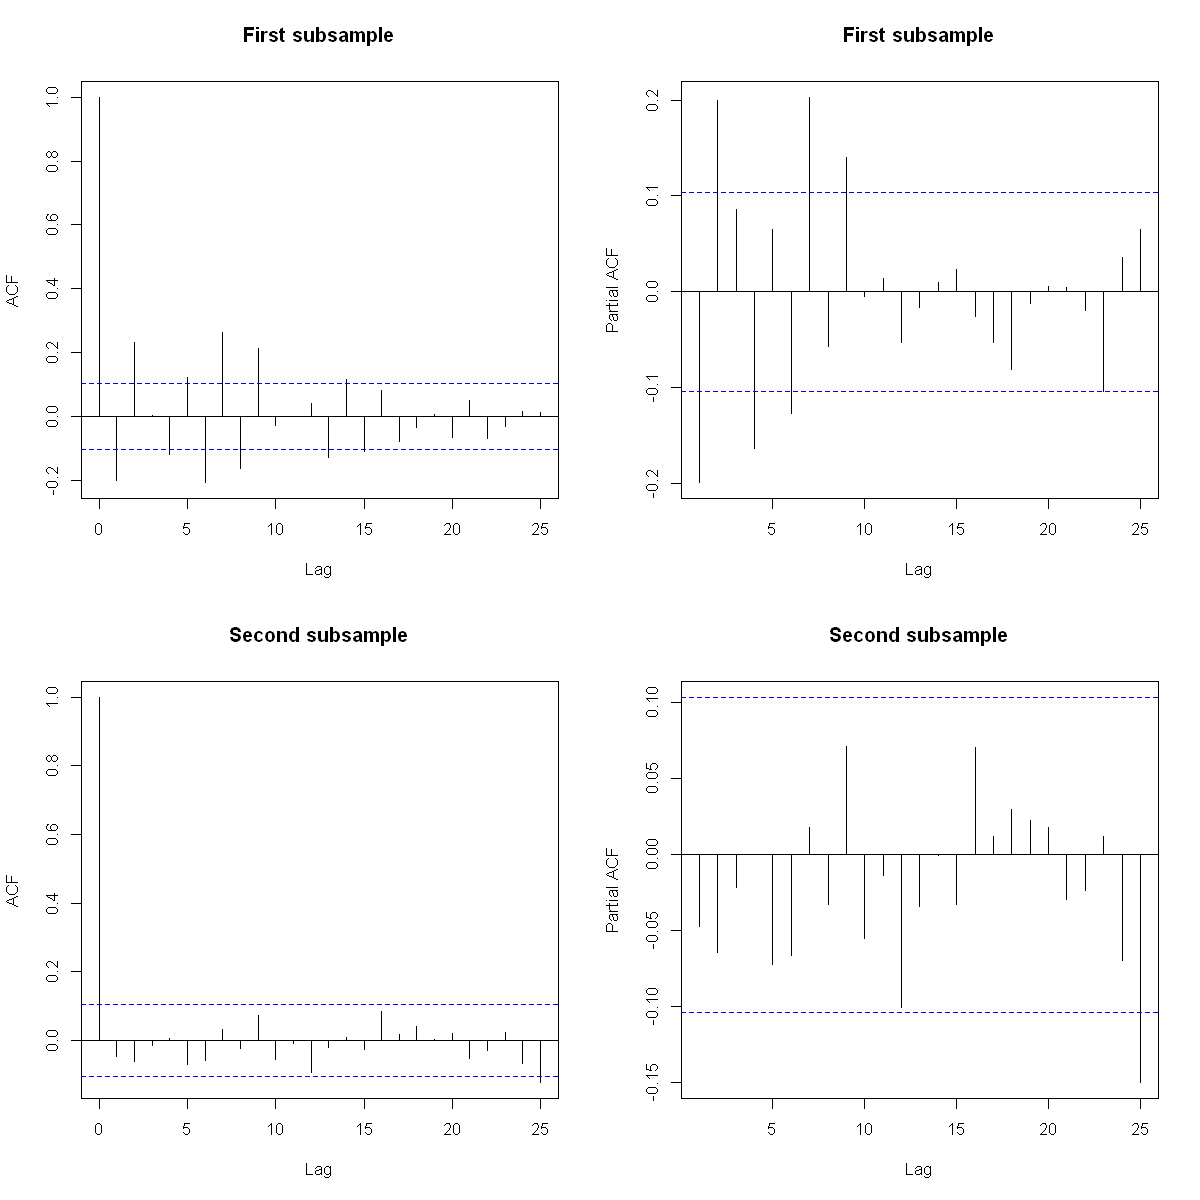

In [77]:
rets1 <- rets[1:(length(rets) / 2)]
rets2 <- rets[((length(rets) / 2) + 1):length(rets)]

options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow = c(2, 2))

acf(rets1, main = "First subsample")
pacf(rets1, main = "First subsample")
acf(rets2, main = "Second subsample")
pacf(rets2, main = "Second subsample")

In [78]:
Box.test(rets1, type = 'Ljung-Box')

adf.test(rets1, k = 1)

kpss.test(rets1, null = 'Level')
kpss.test(rets1, null = 'Trend')


	Box-Ljung test

data:  rets1
X-squared = 14.256, df = 1, p-value = 0.0001596


Warning message in adf.test(rets1, k = 1):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  rets1
Dickey-Fuller = -11.946, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(rets1, null = "Level"):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  rets1
KPSS Level = 0.25259, Truncation lag parameter = 5, p-value = 0.1


Warning message in kpss.test(rets1, null = "Trend"):
"p-value greater than printed p-value"


	KPSS Test for Trend Stationarity

data:  rets1
KPSS Trend = 0.057531, Truncation lag parameter = 5, p-value = 0.1


In [79]:
Box.test(rets2, type = 'Ljung-Box')

adf.test(rets2, k = 1)

kpss.test(rets2, null = 'Level')
kpss.test(rets2, null = 'Trend')


	Box-Ljung test

data:  rets2
X-squared = 0.79975, df = 1, p-value = 0.3712


Warning message in adf.test(rets2, k = 1):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  rets2
Dickey-Fuller = -14.43, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(rets2, null = "Level"):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  rets2
KPSS Level = 0.027273, Truncation lag parameter = 5, p-value = 0.1


Warning message in kpss.test(rets2, null = "Trend"):
"p-value greater than printed p-value"


	KPSS Test for Trend Stationarity

data:  rets2
KPSS Trend = 0.028216, Truncation lag parameter = 5, p-value = 0.1


Based on teh B-L test on the second half of the data it is likely that there is not enough autocorrelation to be able to model the data...

On the other hand the first part of the data seems to be appropriate for modelling.

For the first subsample we might expect similar models and results as for the whole, undivided dataset, since it seems the previous results were driven mainly by the variation in the first half of our dataset.

Series: rets1 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
          ar1     ar2    mean
      -0.1591  0.1981  0.0005
s.e.   0.0518  0.0518  0.0011

sigma^2 estimated as 0.0004222:  log likelihood=879.38
AIC=-1750.77   AICc=-1750.65   BIC=-1735.27

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -2.060327e-09 0.02045994 0.01282684 101.5615 203.3797 0.6467541
                    ACF1
Training set -0.01758718



	Box-Ljung test

data:  rets1_ar2$residuals
X-squared = 0.11104, df = 1, p-value = 0.739



	Box-Ljung test

data:  rets1_ar2$residuals
X-squared = 6.9395, df = 4, p-value = 0.1391



	Box-Ljung test

data:  rets1_ar2$residuals
X-squared = 27.21, df = 8, p-value = 0.0006503



	Box-Ljung test

data:  rets1_ar2$residuals
X-squared = 37.512, df = 12, p-value = 0.0001845


Series: rets1 
ARIMA(4,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4   mean
      -0.1621  0.2463  0.0569  -0.1618  5e-04
s.e.   0.0522  0.0528  0.0529   0.0522  1e-03

sigma^2 estimated as 0.0004102:  log likelihood=885.45
AIC=-1758.9   AICc=-1758.65   BIC=-1735.65

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -1.426065e-06 0.02011075 0.01292931 87.90819 215.0473 0.6519211
                    ACF1
Training set 0.009916784


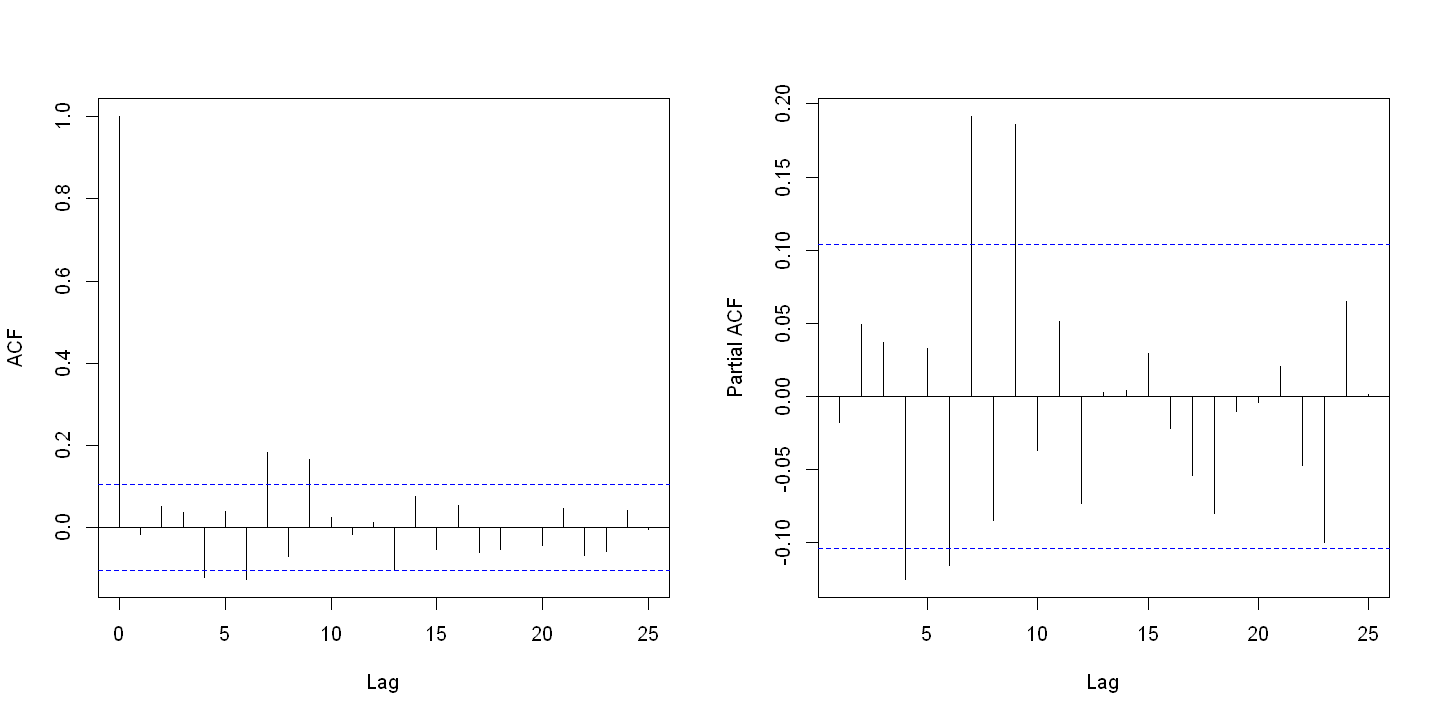


	Box-Ljung test

data:  rets1_ar4$residuals
X-squared = 0.035306, df = 1, p-value = 0.851



	Box-Ljung test

data:  rets1_ar4$residuals
X-squared = 0.61949, df = 4, p-value = 0.9609



	Box-Ljung test

data:  rets1_ar4$residuals
X-squared = 16.208, df = 8, p-value = 0.03949



	Box-Ljung test

data:  rets1_ar4$residuals
X-squared = 25.601, df = 12, p-value = 0.01222


Series: rets1 
ARIMA(7,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4      ar5      ar6     ar7    mean
      -0.1177  0.2143  0.0713  -0.1303  -0.0007  -0.0960  0.2010  0.0005
s.e.   0.0518  0.0519  0.0532   0.0528   0.0531   0.0518  0.0516  0.0012

sigma^2 estimated as 0.0003885:  log likelihood=896.46
AIC=-1774.92   AICc=-1774.4   BIC=-1740.04

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -1.814988e-06 0.01948724 0.01281496 12.94679 261.7732 0.6461553
                   ACF1
Training set 0.01105811


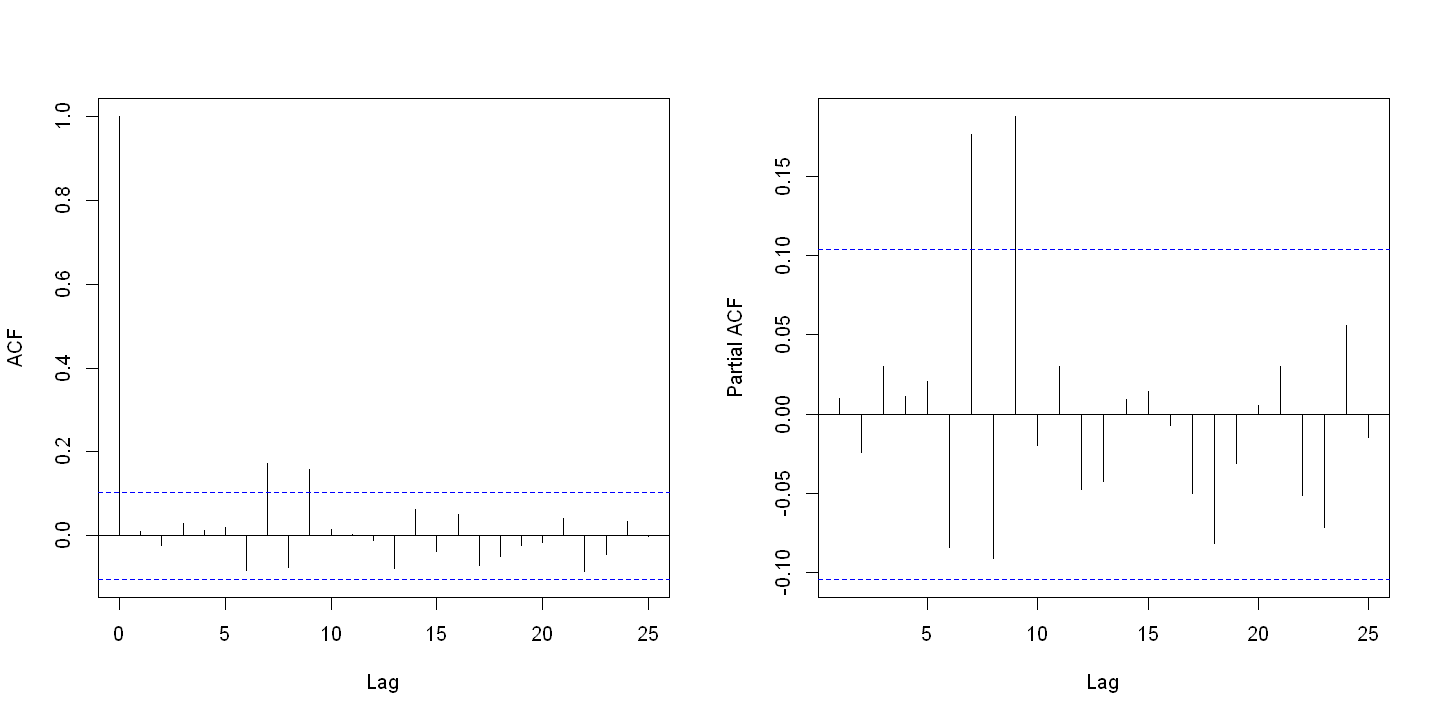


	Box-Ljung test

data:  rets1_ar7$residuals
X-squared = 0.0439, df = 1, p-value = 0.834



	Box-Ljung test

data:  rets1_ar7$residuals
X-squared = 0.73689, df = 4, p-value = 0.9467



	Box-Ljung test

data:  rets1_ar7$residuals
X-squared = 2.0537, df = 8, p-value = 0.9793



	Box-Ljung test

data:  rets1_ar7$residuals
X-squared = 9.3133, df = 12, p-value = 0.676


Series: rets1 
ARIMA(9,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ar5      ar6     ar7      ar8
      -0.0982  0.1810  0.0834  -0.1380  0.0229  -0.0943  0.1651  -0.0404
s.e.   0.0524  0.0526  0.0528   0.0527  0.0531   0.0526  0.0525   0.0524
         ar9    mean
      0.1386  0.0006
s.e.  0.0520  0.0013

sigma^2 estimated as 0.0003817:  log likelihood=900.53
AIC=-1779.05   AICc=-1778.29   BIC=-1736.43

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 1.435143e-08 0.01926056 0.01267231 13.27227 262.8292 0.6389625
                     ACF1
Training set 0.0005181632


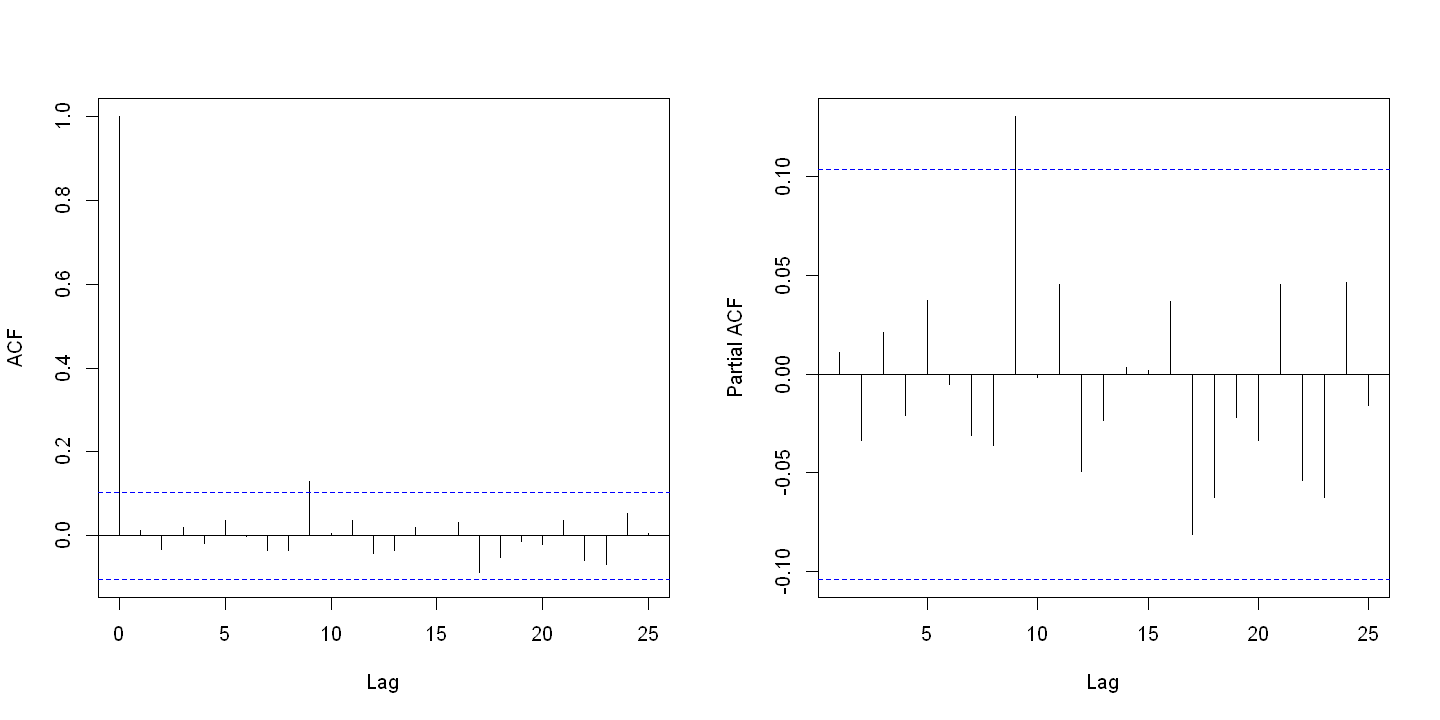


	Box-Ljung test

data:  rets1_ar9$residuals
X-squared = 9.6391e-05, df = 1, p-value = 0.9922



	Box-Ljung test

data:  rets1_ar9$residuals
X-squared = 0.045704, df = 4, p-value = 0.9997



	Box-Ljung test

data:  rets1_ar9$residuals
X-squared = 0.14828, df = 8, p-value = 1



	Box-Ljung test

data:  rets1_ar9$residuals
X-squared = 1.6578, df = 12, p-value = 0.9998


Series: rets1 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
          ma1   mean
      -0.1393  5e-04
s.e.   0.0435  1e-03

sigma^2 estimated as 0.0004438:  log likelihood=870.03
AIC=-1734.05   AICc=-1733.99   BIC=-1722.43

Training set error measures:
                        ME       RMSE       MAE      MPE     MAPE      MASE
Training set -1.950892e-06 0.02100778 0.0129318 115.6798 136.0593 0.6520464
                    ACF1
Training set -0.03289618


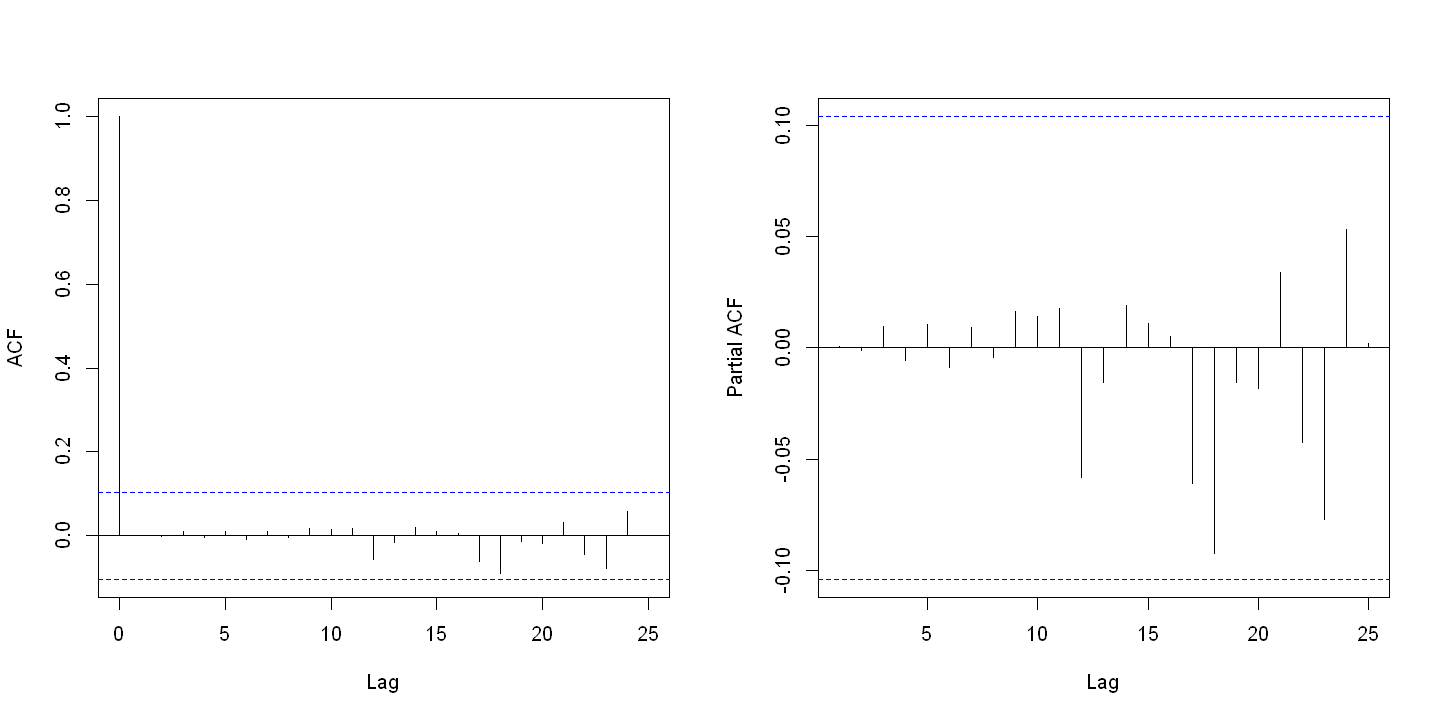


	Box-Ljung test

data:  rets1_ma1$residuals
X-squared = 0.3885, df = 1, p-value = 0.5331



	Box-Ljung test

data:  rets1_ma1$residuals
X-squared = 23.697, df = 4, p-value = 9.187e-05



	Box-Ljung test

data:  rets1_ma1$residuals
X-squared = 59.882, df = 8, p-value = 4.915e-10



	Box-Ljung test

data:  rets1_ma1$residuals
X-squared = 75.153, df = 12, p-value = 3.438e-11


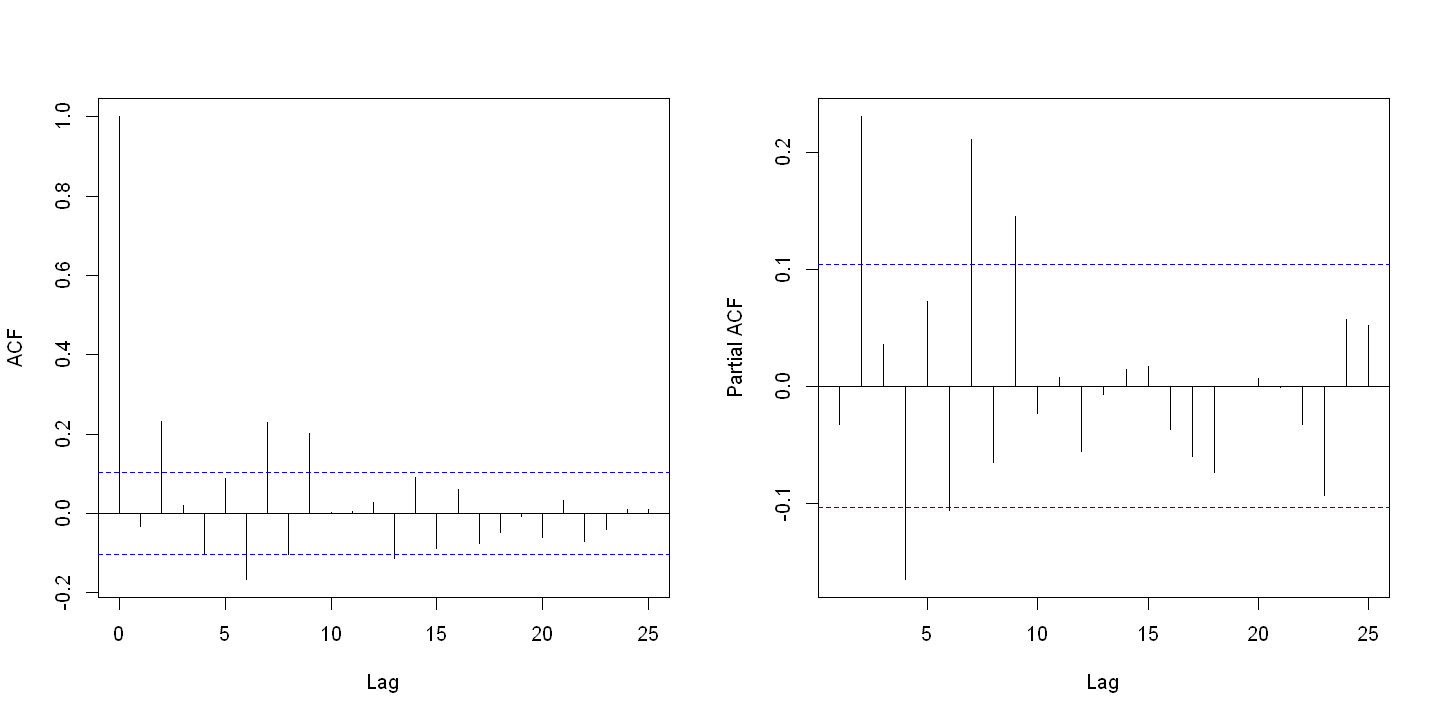

In [81]:
options(repr.plot.width = 12, repr.plot.height = 6)

# ar2
library(forecast)
rets1_ar2 <- Arima(rets1, order = c(2, 0, 0))
summary (rets1_ar2)

par(mfrow = c(1, 2))
acf(rets1_ar2$residuals, main = NA)
pacf(rets1_ar2$residuals, main = NA)


Box.test(rets1_ar2$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets1_ar2$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets1_ar2$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets1_ar2$residuals, type = "Ljung-Box", lag = 12)


# ar4
library(forecast)
rets1_ar4 <- Arima(rets1, order = c(4, 0, 0))
summary (rets1_ar4)

par(mfrow = c(1, 2))
acf(rets1_ar4$residuals, main = NA)
pacf(rets1_ar4$residuals, main = NA)

Box.test(rets1_ar4$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets1_ar4$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets1_ar4$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets1_ar4$residuals, type = "Ljung-Box", lag = 12)



# ar7
library(forecast)
rets1_ar7 <- Arima(rets1, order = c(7, 0, 0))
summary (rets1_ar7)

par(mfrow = c(1, 2))
acf(rets1_ar7$residuals, main = NA)
pacf(rets1_ar7$residuals, main = NA)

Box.test(rets1_ar7$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets1_ar7$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets1_ar7$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets1_ar7$residuals, type = "Ljung-Box", lag = 12)


# ar9
library(forecast)
rets1_ar9 <- Arima(rets1, order = c(9, 0, 0))
summary (rets1_ar9)

par(mfrow = c(1, 2))
acf(rets1_ar9$residuals, main = NA)
pacf(rets1_ar9$residuals, main = NA)

Box.test(rets1_ar9$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets1_ar9$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets1_ar9$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets1_ar9$residuals, type = "Ljung-Box", lag = 12)



# ma1
library(forecast)
rets1_ma1 <- Arima(rets1, order = c(0, 0, 1))
summary (rets1_ma1)

par(mfrow = c(1, 2))
acf(rets1_ma1$residuals, main = NA)
pacf(rets1_ma1$residuals, main = NA)

Box.test(rets1_ma1$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets1_ma1$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets1_ma1$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets1_ma1$residuals, type = "Ljung-Box", lag = 12)



In [82]:
auto.arima(rets1)

Series: rets1 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.1580  0.2797
s.e.   0.0503  0.0523

sigma^2 estimated as 0.0004144:  log likelihood=882.14
AIC=-1758.28   AICc=-1758.21   BIC=-1746.65

Series: rets1 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.1580  0.2797
s.e.   0.0503  0.0523

sigma^2 estimated as 0.0004144:  log likelihood=882.14
AIC=-1758.28   AICc=-1758.21   BIC=-1746.65

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE     MASE
Training set 0.0004766286 0.02030063 0.01299101 78.70362 233.5327 0.655032
                     ACF1
Training set -0.009326796



	Box-Ljung test

data:  rets1_ma2$residuals
X-squared = 0.03123, df = 1, p-value = 0.8597



	Box-Ljung test

data:  rets1_ma2$residuals
X-squared = 2.4451, df = 4, p-value = 0.6545



	Box-Ljung test

data:  rets1_ma2$residuals
X-squared = 22.311, df = 8, p-value = 0.004371



	Box-Ljung test

data:  rets1_ma2$residuals
X-squared = 32.387, df = 12, p-value = 0.001206


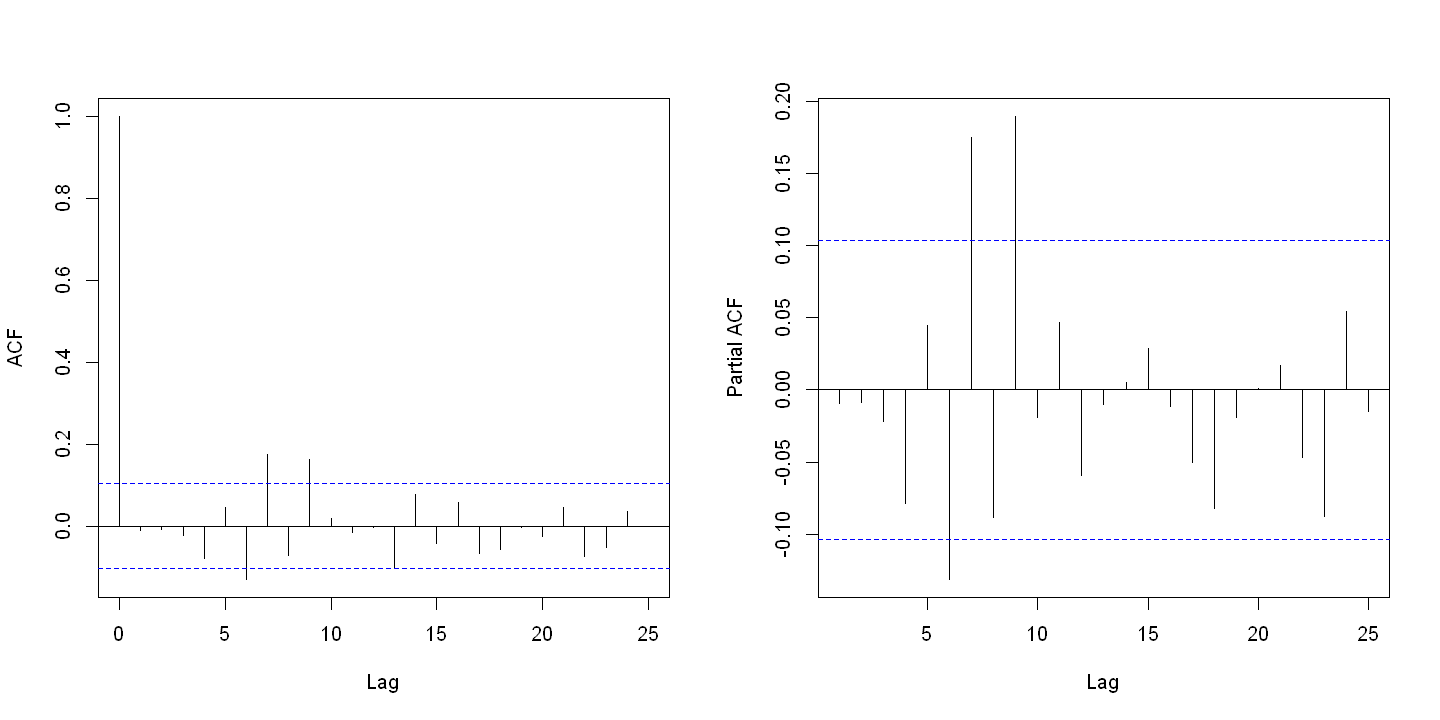

In [83]:
library(forecast)
rets1_ma2 <- Arima(rets1, order = c(0, 0, 2), include.mean = FALSE)
summary(rets1_ma2)

par(mfrow = c(1, 2))
acf(rets1_ma2$residuals, main = NA)
pacf(rets1_ma2$residuals, main = NA)


Box.test(rets1_ma2$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets1_ma2$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets1_ma2$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets1_ma2$residuals, type = "Ljung-Box", lag = 12)

Series: rets1 
ARIMA(4,0,2) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ma1      ma2    mean
      -0.6490  0.4019  0.1967  -0.1853  0.5526  -0.2604  0.0005
s.e.   0.4625  0.4701  0.0690   0.1411  0.4672   0.4179  0.0011

sigma^2 estimated as 0.0003893:  log likelihood=895.58
AIC=-1775.17   AICc=-1774.75   BIC=-1744.17

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -1.188232e-06 0.01953526 0.01259296 53.73522 211.3697 0.6349615
                   ACF1
Training set 0.00136825



	Box-Ljung test

data:  rets1_arma42$residuals
X-squared = 0.0006721, df = 1, p-value = 0.9793



	Box-Ljung test

data:  rets1_arma42$residuals
X-squared = 0.43947, df = 4, p-value = 0.9791



	Box-Ljung test

data:  rets1_arma42$residuals
X-squared = 4.5201, df = 8, p-value = 0.8074



	Box-Ljung test

data:  rets1_arma42$residuals
X-squared = 9.4134, df = 12, p-value = 0.6673


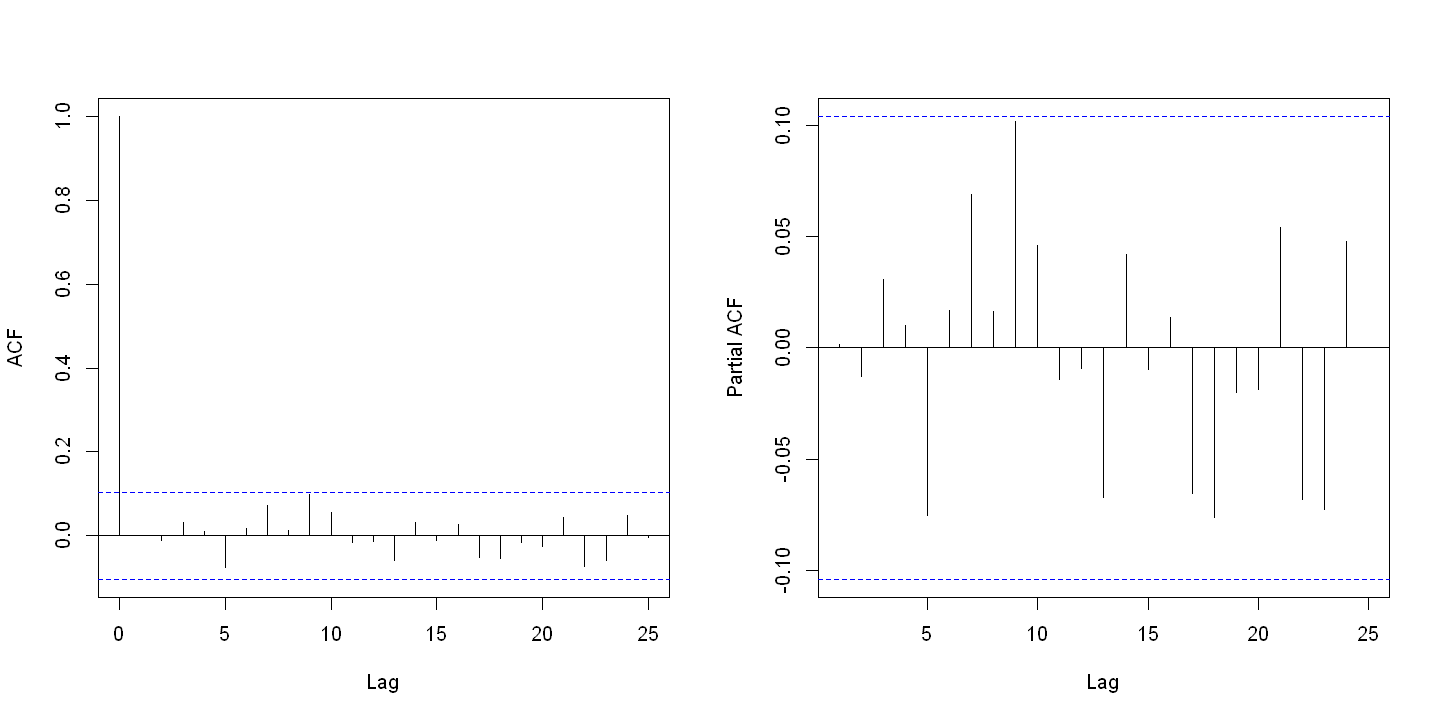

In [84]:
library(forecast)
rets1_arma42 <- Arima(rets1, order = c(4, 0, 2))
summary (rets1_arma42)

par(mfrow = c(1, 2))
acf(rets1_arma42$residuals, main = NA)
pacf(rets1_arma42$residuals, main = NA)

Box.test(rets1_arma42$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets1_arma42$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets1_arma42$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets1_arma42$residuals, type = "Ljung-Box", lag = 12)

In [85]:
models <- 7
criteria <- matrix(ncol = 2, nrow = models)
colnames(criteria) <- c('AIC', 'BIC')
rownames(criteria) <- c('AR(2)','AR(4)', 'AR(7)', 'AR(9)','ARMA(4,2)','MA(1)','MA(2)')

criteria[1, 1] <- rets1_ar2$aic
criteria[1, 2] <- rets1_ar2$bic
criteria[2, 1] <- rets1_ar4$aic
criteria[2, 2] <- rets1_ar4$bic
criteria[3, 1] <- rets1_ar7$aic
criteria[3, 2] <- rets1_ar7$bic

criteria[4, 1] <- rets1_ar9$aic
criteria[4, 2] <- rets1_ar9$bic
criteria[5, 1] <- rets1_arma42$aic
criteria[5, 2] <- rets1_arma42$bic
criteria[6, 1] <- rets1_ma1$aic
criteria[6, 2] <- rets1_ma1$bic
criteria[7, 1] <- rets1_ma2$aic
criteria[7, 2] <- rets1_ma2$bic

criteria

,AIC,BIC
AR(2),-1750.767,-1735.268
AR(4),-1758.896,-1735.646
AR(7),-1774.919,-1740.045
AR(9),-1779.055,-1736.430
"ARMA(4,2)",-1775.166,-1744.167
MA(1),-1734.054,-1722.429
MA(2),-1758.275,-1746.650


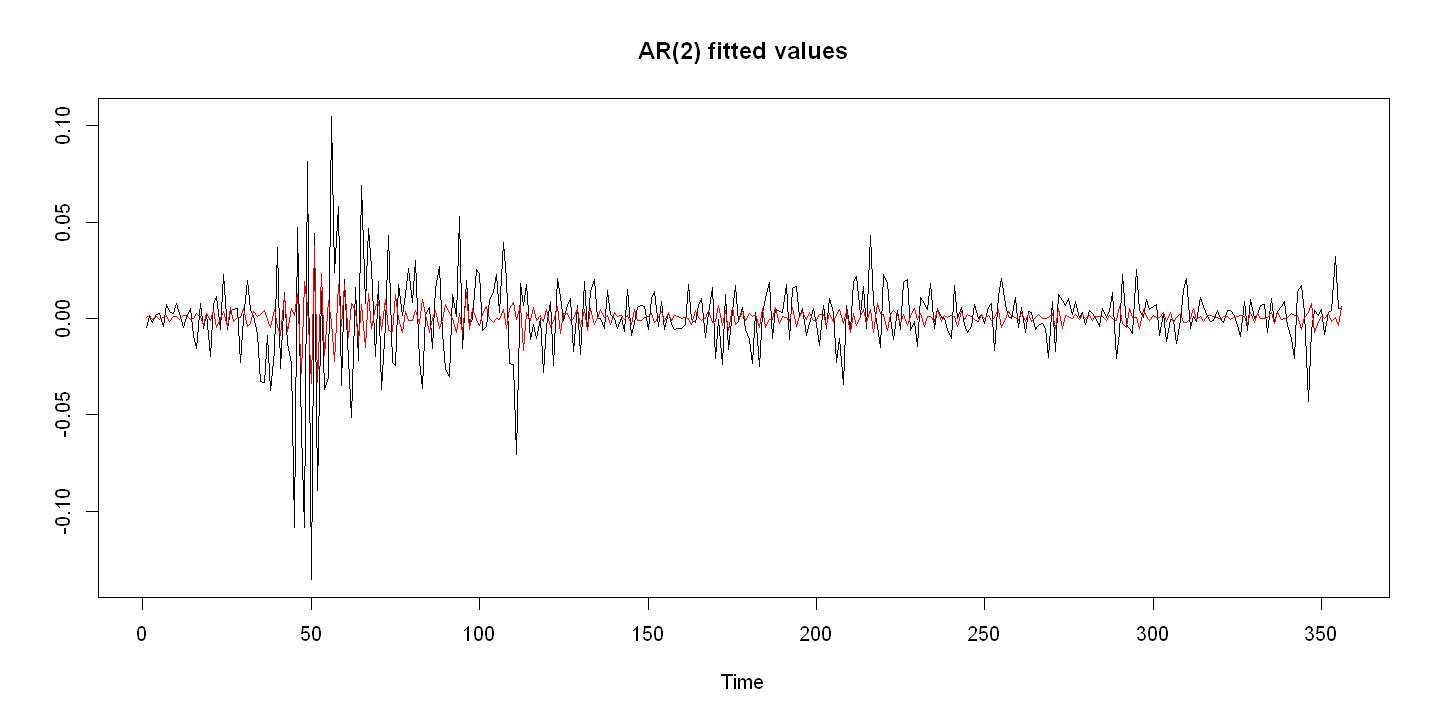

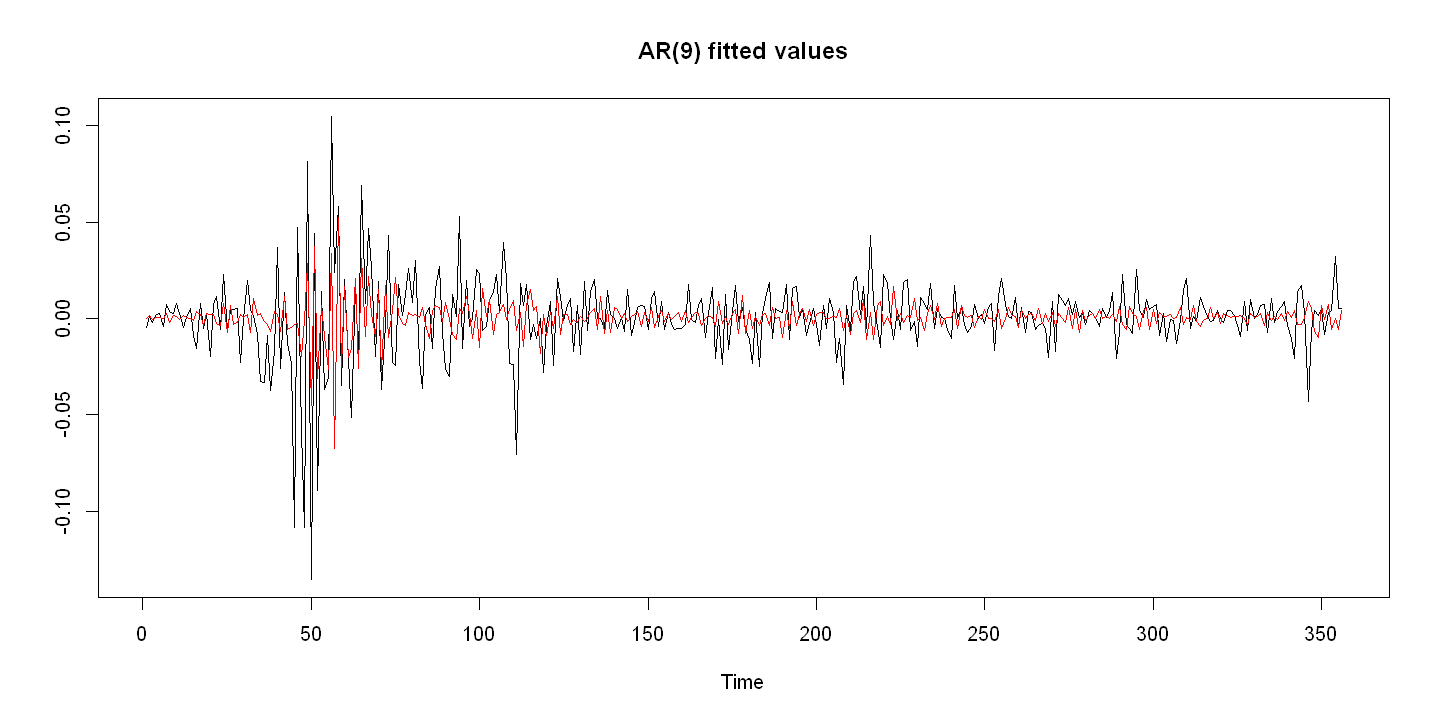

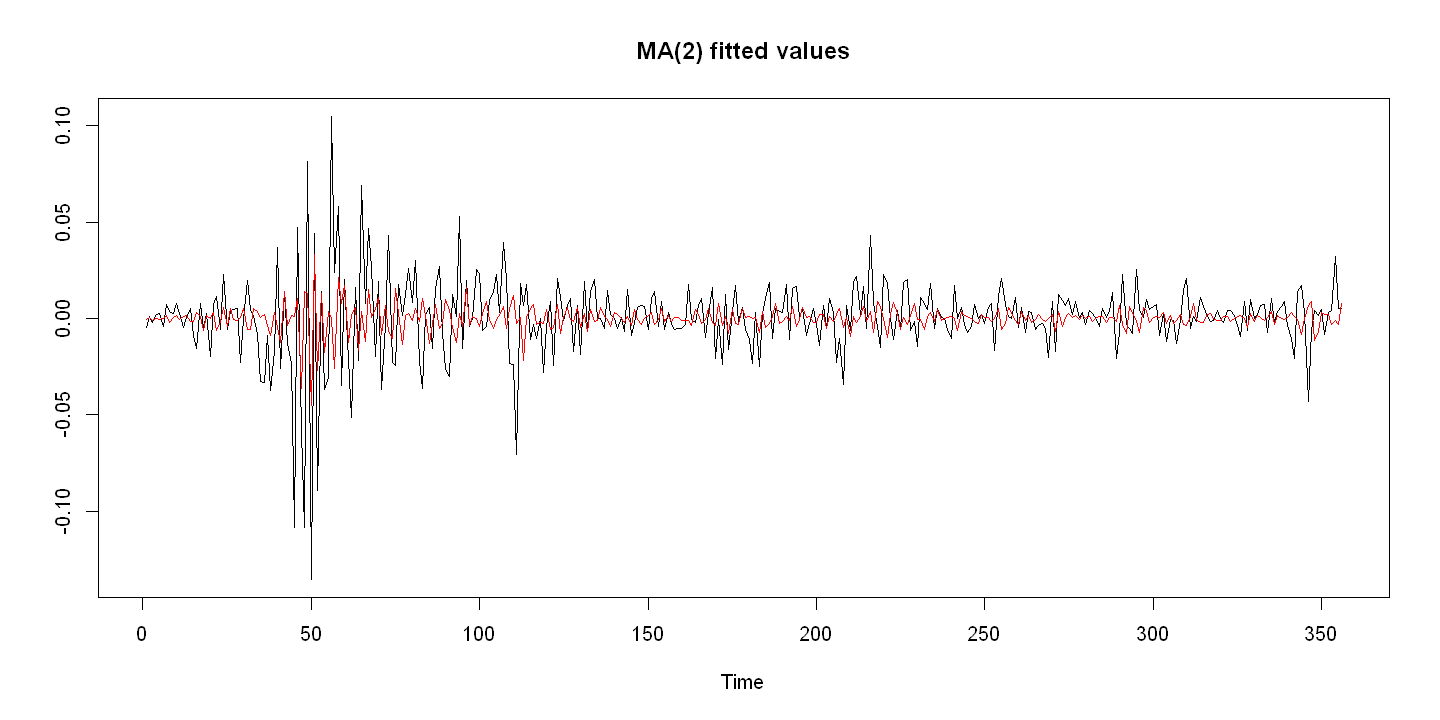

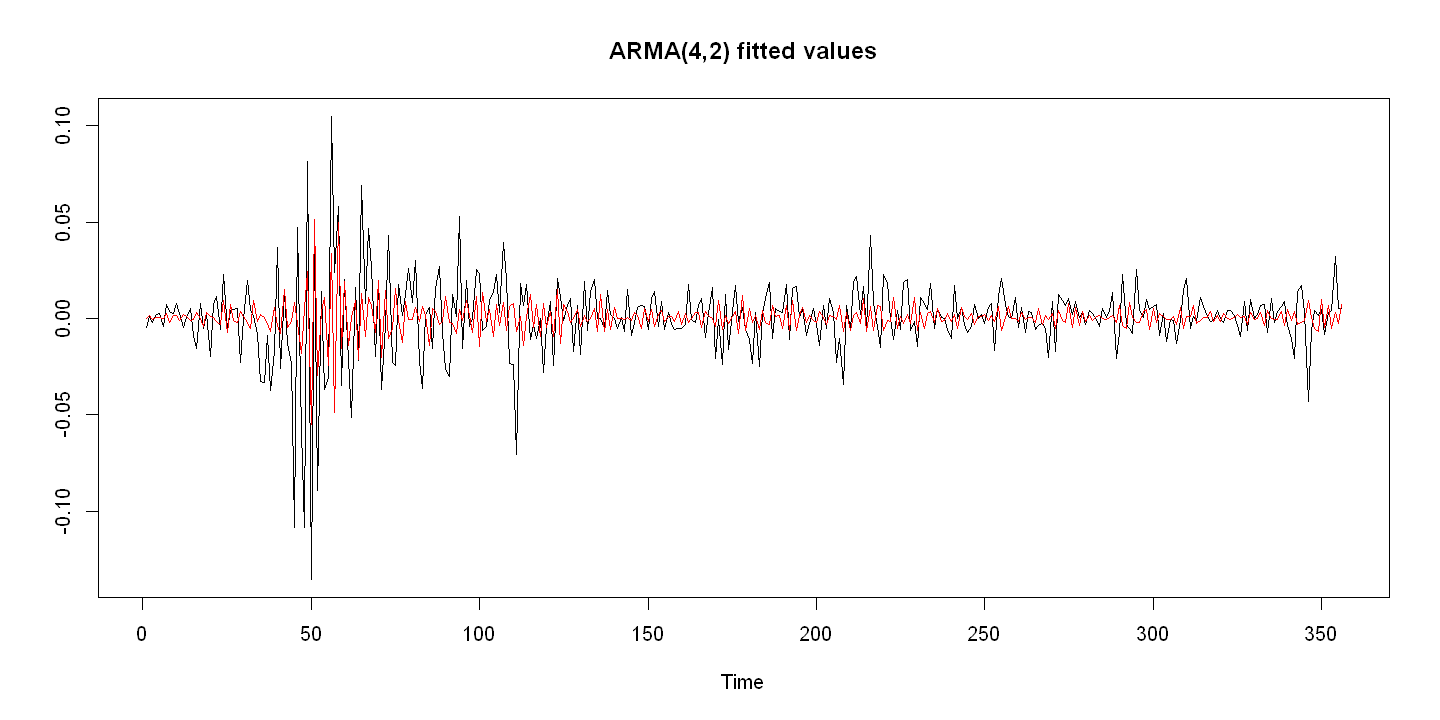

In [87]:
options(repr.plot.width = 12, repr.plot.height = 6)

plot.ts(rets1, ylab = NA, main = 'AR(2) fitted values')
lines(rets1_ar2$fitted, col = 'red')

plot.ts(rets1, ylab = NA, main = 'AR(9) fitted values')
lines(rets1_ar9$fitted, col = 'red')

plot.ts(rets1, ylab = NA, main = 'MA(2) fitted values')
lines(rets1_ma2$fitted, col = 'red')

plot.ts(rets1, ylab = NA, main = 'ARMA(4,2) fitted values')
lines(rets1_arma42$fitted, col = 'red')

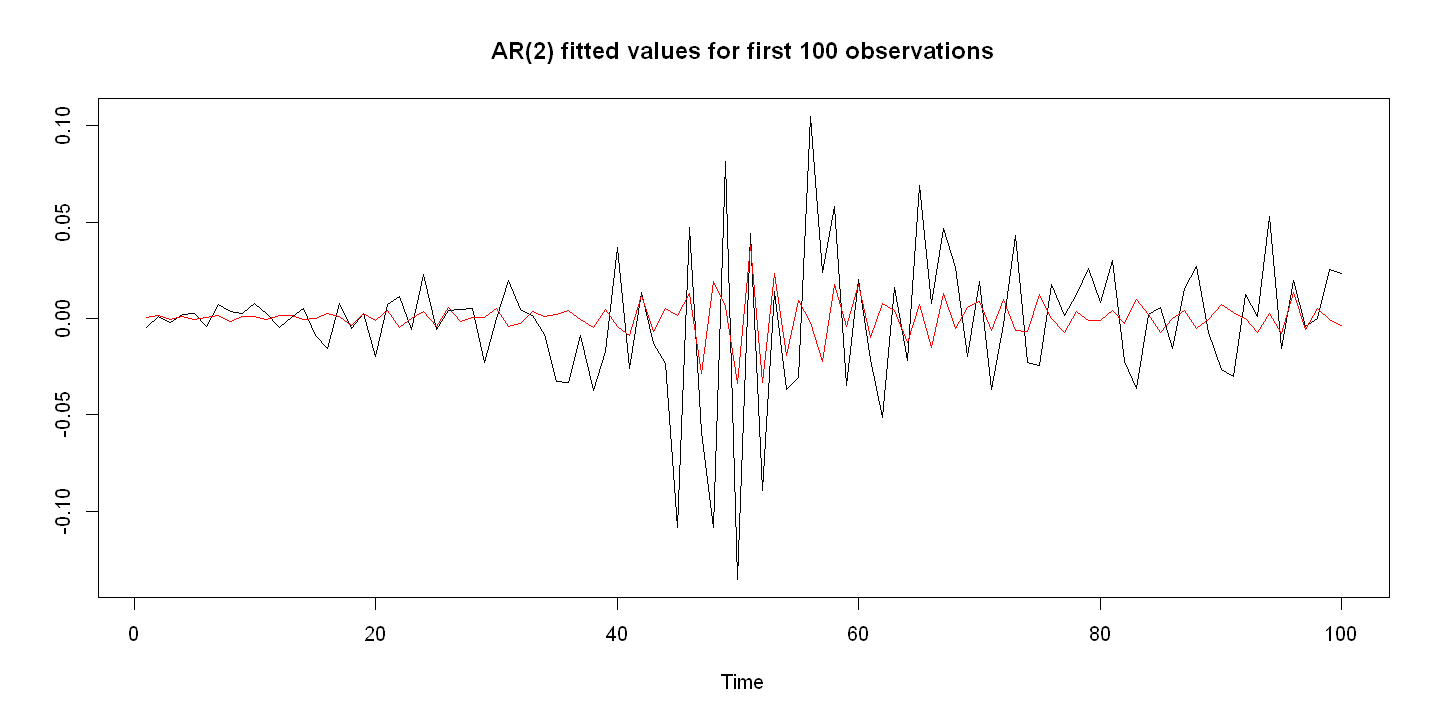

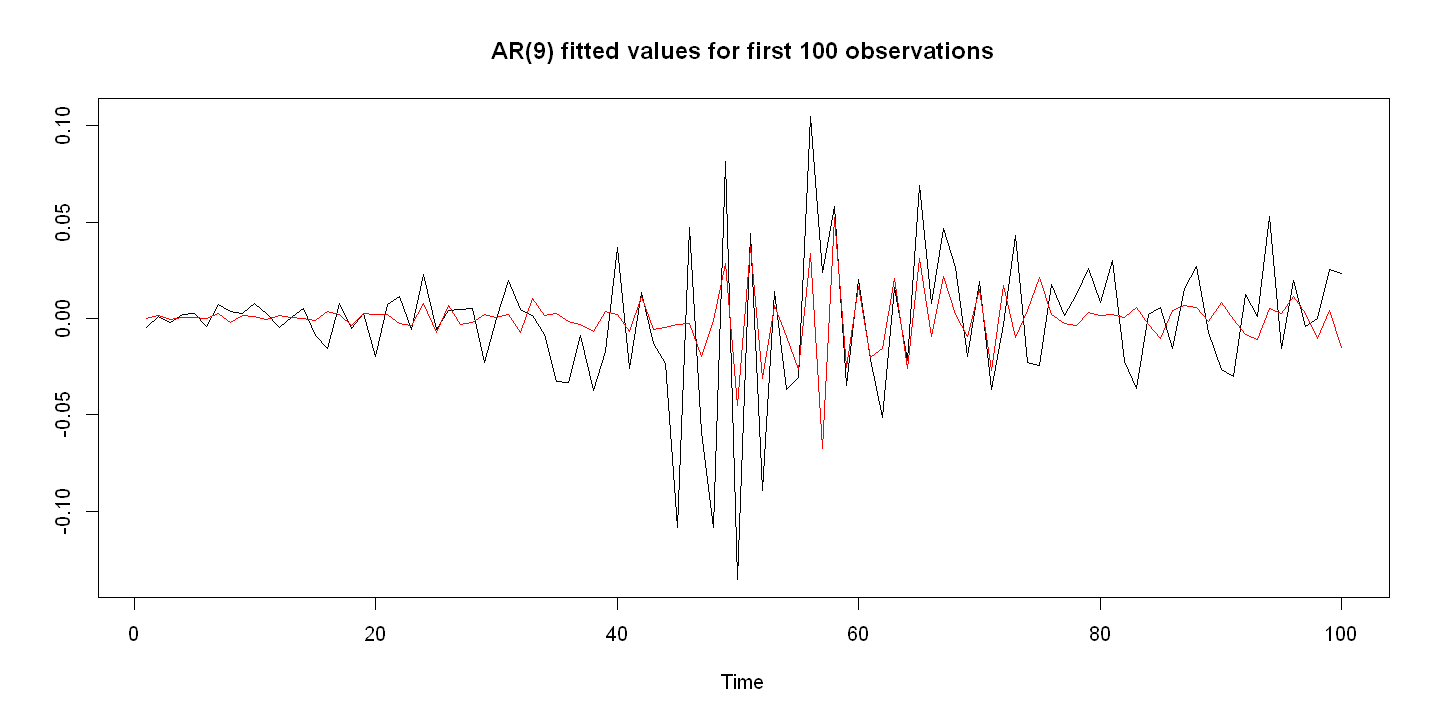

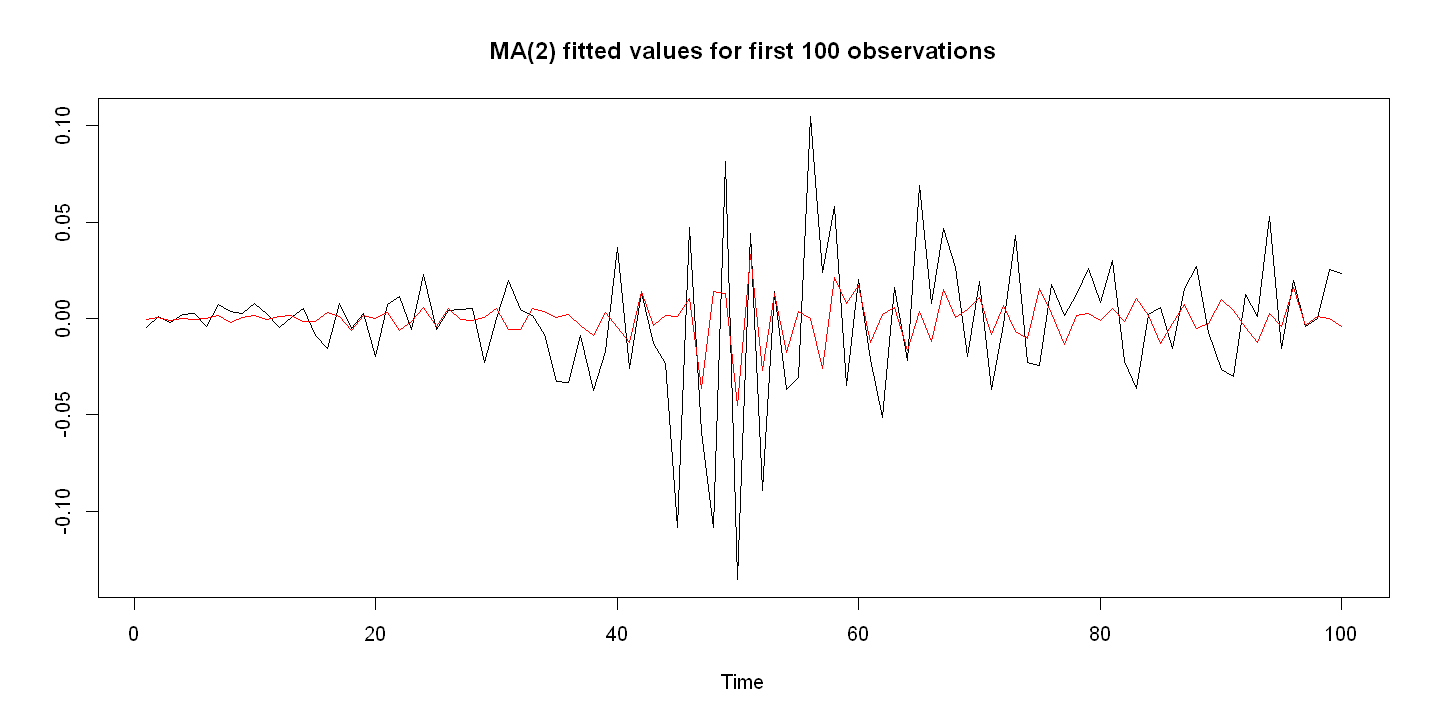

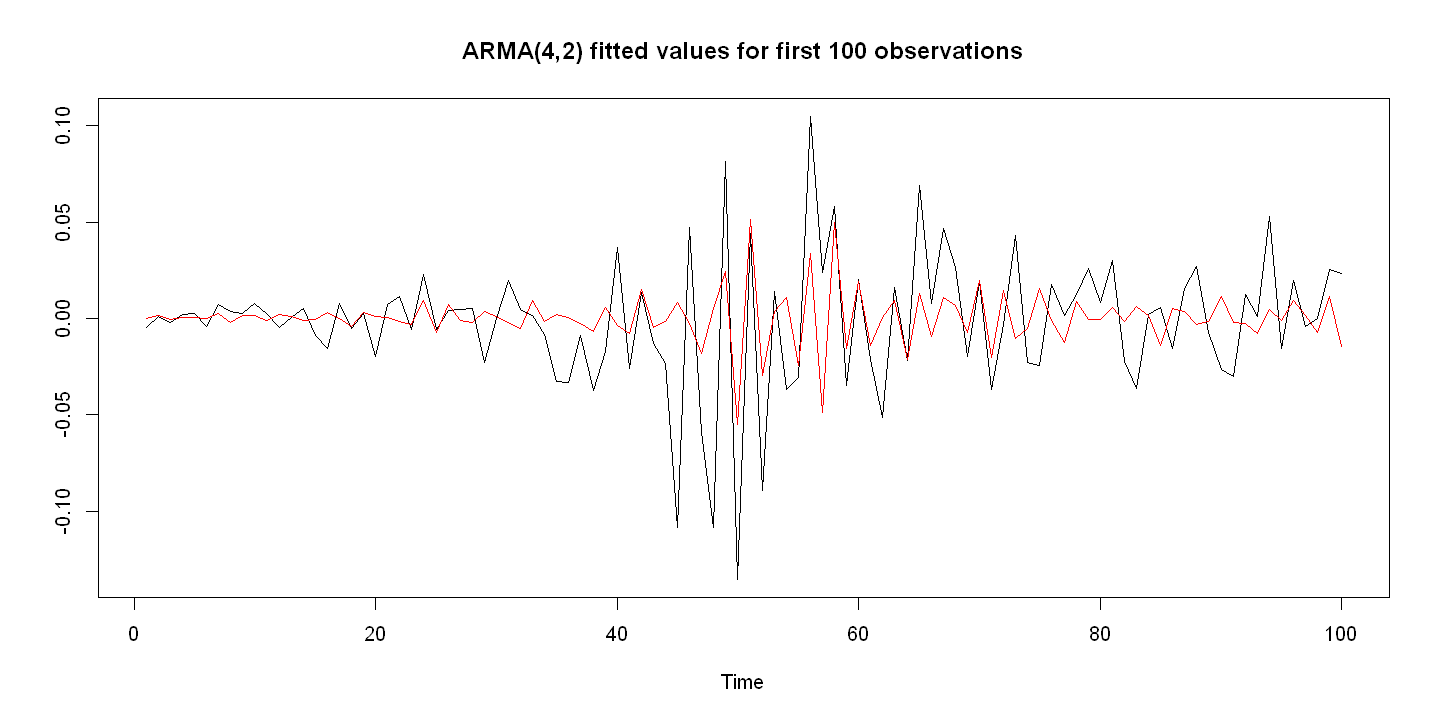

In [89]:
options(repr.plot.width = 12, repr.plot.height = 6)

# AR(2) Model
plot.ts(rets1[1:100], ylab = NA, main = 'AR(2) fitted values for first 100 observations')
lines(rets1_ar2$fitted[1:100], col = 'red')

# AR(9) Model
plot.ts(rets1[1:100], ylab = NA, main = 'AR(9) fitted values for first 100 observations')
lines(rets1_ar9$fitted[1:100], col = 'red')

# MA(2) Model
plot.ts(rets1[1:100], ylab = NA, main = 'MA(2) fitted values for first 100 observations')
lines(rets1_ma2$fitted[1:100], col = 'red')

# ARMA(4,2) Model
plot.ts(rets1[1:100], ylab = NA, main = 'ARMA(4,2) fitted values for first 100 observations')
lines(rets1_arma42$fitted[1:100], col = 'red')